<h1>Credit Score Model

<h3>Variable Infomation</h3>
<p>-BAD: 1 = người nộp đơn đã vỡ nợ hoặc nợ quá hạn nghiêm trọng; 0 = người nộp đơn đã thanh toán khoản vay 
<p>-LOAN: Số tiền yêu cầu vay
<p>-MORTDUE: Số tiền nợ còn lại trên khoản thế chấp hiện tại
<p>-VALUE: Giá trị tài sản hiện tại.
<p>-REASON: lý do vay DebtCon = debt consolidation (ghép nợ); HomeImp = home improvement (sửa sang nhà cửa).
<p>-JOB: loại công việc, bao gồm các nhóm “Office”, “Sales”, “Mananger”, “Professional Executive”, “Self business” và các công việc khác.
<p>-YOJ: Số năm làm việc tại công việc hiện tại
<p>-DEROG: Số lượng báo cáo vỡ nợ.
<p>-DELINQ: Số hạn mức tín dụng quá hạn
<p>-CLAGE:Tuổi của hạn mức tín dụng lâu nhất tính theo tháng
<p>-NINQ: Số lượng yêu cầu tín dụng gần đây
<p>-CLNO: Số lượng hạn mức tín dụng
<p>-DEBTINC: Tỷ lệ nợ/thu nhập

<h3> Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from scipy.stats import probplot
from statistics import mean, stdev
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix, f1_score, classification_report, mean_absolute_error, log_loss
from sklearn.model_selection import KFold, cross_val_score, cross_validate, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.svm import SVC 
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import pickle

In [2]:
%matplotlib inline

<h3>Import data</h3>

In [2]:
# Đọc dữ liệu từ file hmeq.csv
df = pd.read_csv('./hmeq.csv')

<h3>Understanding the data

In [4]:
df.head()

BAD  LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1  1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1    1  1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2    1  1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3    1  1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4    0  1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   

        CLAGE  NINQ  CLNO  DEBTINC  
0   94.366667   1.0   9.0      NaN  
1  121.833333   0.0  14.0      NaN  
2  149.466667   1.0  10.0      NaN  
3         NaN   NaN   NaN      NaN  
4   93.333333   0.0  14.0      NaN

In [5]:
# Các trường của dữ liệu
df.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

In [6]:
print(df.shape)       
print(df.info())

(5960, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB
None


<p>Tập dữ liệu chứa tổng cộng 5960 hàng và 13 cột.
<p>Cột "BAD" là biến mục tiêu, cho biết khách hàng có vỡ nợ (1) hay không vỡ nợ (0) khi thanh toán khoản vay của họ. 

<p>Bộ dữ liệu bao gồm 9 trường là dữ liệu số: "LOAN," "MORTDUE," "VALUE," "YOJ," "DEROG," "DELINQ," "CLAGE," "NINQ," "CLNO" và "DEBTINC".
<p>Bộ dữ liệu cũng bao gồm 2 trường phân loại: "REASON" và "JOB".
<p>Một số cột bị thiếu giá trị: "MORTDUE", "VALUE", "REASON", "JOB", "YOJ", "DEROG", "DELINQ", "CLAGE", "NINQ", "CLNO" và "DEBTINC".

In [7]:
# Các mô tả thống kê với các biến dạng numerical
df.describe()

BAD          LOAN        MORTDUE          VALUE          YOJ  \
count  5960.000000   5960.000000    5442.000000    5848.000000  5445.000000   
mean      0.199497  18607.969799   73760.817200  101776.048741     8.922268   
std       0.399656  11207.480417   44457.609458   57385.775334     7.573982   
min       0.000000   1100.000000    2063.000000    8000.000000     0.000000   
25%       0.000000  11100.000000   46276.000000   66075.500000     3.000000   
50%       0.000000  16300.000000   65019.000000   89235.500000     7.000000   
75%       0.000000  23300.000000   91488.000000  119824.250000    13.000000   
max       1.000000  89900.000000  399550.000000  855909.000000    41.000000   

             DEROG       DELINQ        CLAGE         NINQ         CLNO  \
count  5252.000000  5380.000000  5652.000000  5450.000000  5738.000000   
mean      0.254570     0.449442   179.766275     1.186055    21.296096   
std       0.846047     1.127266    85.810092     1.728675    10.138933   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000   115.116702     0.000000    15.000000   
50%       0.000000     0.000000   173.466667     1.000000    20.000000   
75%       0.000000     0.000000   231.562278     2.000000    26.000000   
max      10.000000    15.000000  1168.233561    17.000000    71.000000   

           DEBTINC  
count  4693.000000  
mean     33.779915  
std       8.601746  
min       0.524499  
25%      29.140031  
50%      34.818262  
75%      39.003141  
max     203.312149

<p>BAD: Cột "BAD" thể hiện việc khách hàng vỡ nợ (1) hay không vỡ nợ (0) khi thanh toán khoản vay của họ. Tỷ lệ vỡ nợ trung bình là khoảng 19,95%.

LOAN: Cột “LOAN” thể hiện số tiền vay mà khách hàng yêu cầu. Số tiền cho vay trung bình là khoảng 18.608 với nhiều giá trị khác nhau. Số tiền vay cao nhất là khoảng 89.900.

MORTDUE: Cột "MORTDUE" thể hiện số tiền thế chấp hiện tại đến hạn đối với tài sản. Khoản thế chấp trung bình đến hạn là khoảng 73.761.

VALUE: Cột "VALUE" biểu thị giá trị của thuộc tính. Giá trị thuộc tính trung bình là khoảng 101.776, với nhiều giá trị khác nhau. Giá trị tài sản cao nhất là 855.909.

REASON: Cột "REASON" thể hiện lý do cho khoản vay, với hai giá trị duy nhất: "DebtCon" (Hợp nhất Nợ) và "HomeImp" ​​(Cải thiện Nhà). Lý do phổ biến nhất cho khoản vay là hợp nhất nợ (DebtCon).

JOB: Cột "JOB" thể hiện loại công việc của khách hàng. Có sáu loại công việc riêng biệt, trong đó "Other" là loại công việc phổ biến nhất.

YOJ: Cột "YOJ" thể hiện số năm làm việc của khách hàng. Số năm làm việc trung bình là khoảng 8,92 năm.

DEROG: Cột "DEROG" thể hiện số lượng báo cáo vỡ nợ của khách hàng. Số lượng báo cáo vỡ nợ trung bình là khoảng 0,25.

DELINQ: Cột "DELINQ" biểu thị số hạn mức tín dụng quá hạn trong lịch sử tín dụng của khách hàng. Số hạn mức tín dụng quá hạn trung bình là khoảng 0,45.

CLAGE: Cột "CLAGE" thể hiện tuổi của dòng tín dụng lâu đời nhất tính theo tháng. Tuổi trung bình của dòng tín dụng lâu đời nhất là khoảng 179,77 tháng.

NINQ: Cột "NINQ" biểu thị số hạn mức tín dụng gần đây trong lịch sử tín dụng của khách hàng. Số hạn mức tín dụng trung bình gần đây là khoảng 1,19.

CLNO: Cột "CLNO" biểu thị số hạn mức tín dụng trong lịch sử tín dụng của khách hàng. Số hạn mức tín dụng trung bình là khoảng 21,30.

DEBTINC: Cột "DEBTINC" thể hiện tỷ lệ nợ trên thu nhập của khách hàng. Tỷ lệ nợ trên thu nhập trung bình là khoảng 33,78.

<h3>Split the Dataset into Training Data and Test Data

In [3]:
y = df["BAD"]                   # y là các giá trị cột BAD
X = df.drop(["BAD"],axis=1)     # X là các cột còn lại

In [4]:
# split dataframe
x_train, x_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42, test_size=0.2)

In [13]:
def show_outlier(df):
    fig, ax = plt.subplots(2,5,figsize=(20,10))
    row = 0
    column = 0
    for name_column in ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']:
        # if df[name_column].dtype == 'object':
        #     ax[row, column].bar(list(df[name_column].value_counts().keys()), list(df[name_column].value_counts().values))
        #     ax[row,column].set_title(name_column)
        # else:
        ax[row, column].boxplot(df[name_column])
        ax[row, column].set_xticks([])
        ax[row,column].set_title(name_column)
    
        if column == 4: 
            row += 1
            column = 0
        else:
            column+=1

In [11]:
x_train = x_train.dropna(axis=0, how='any')

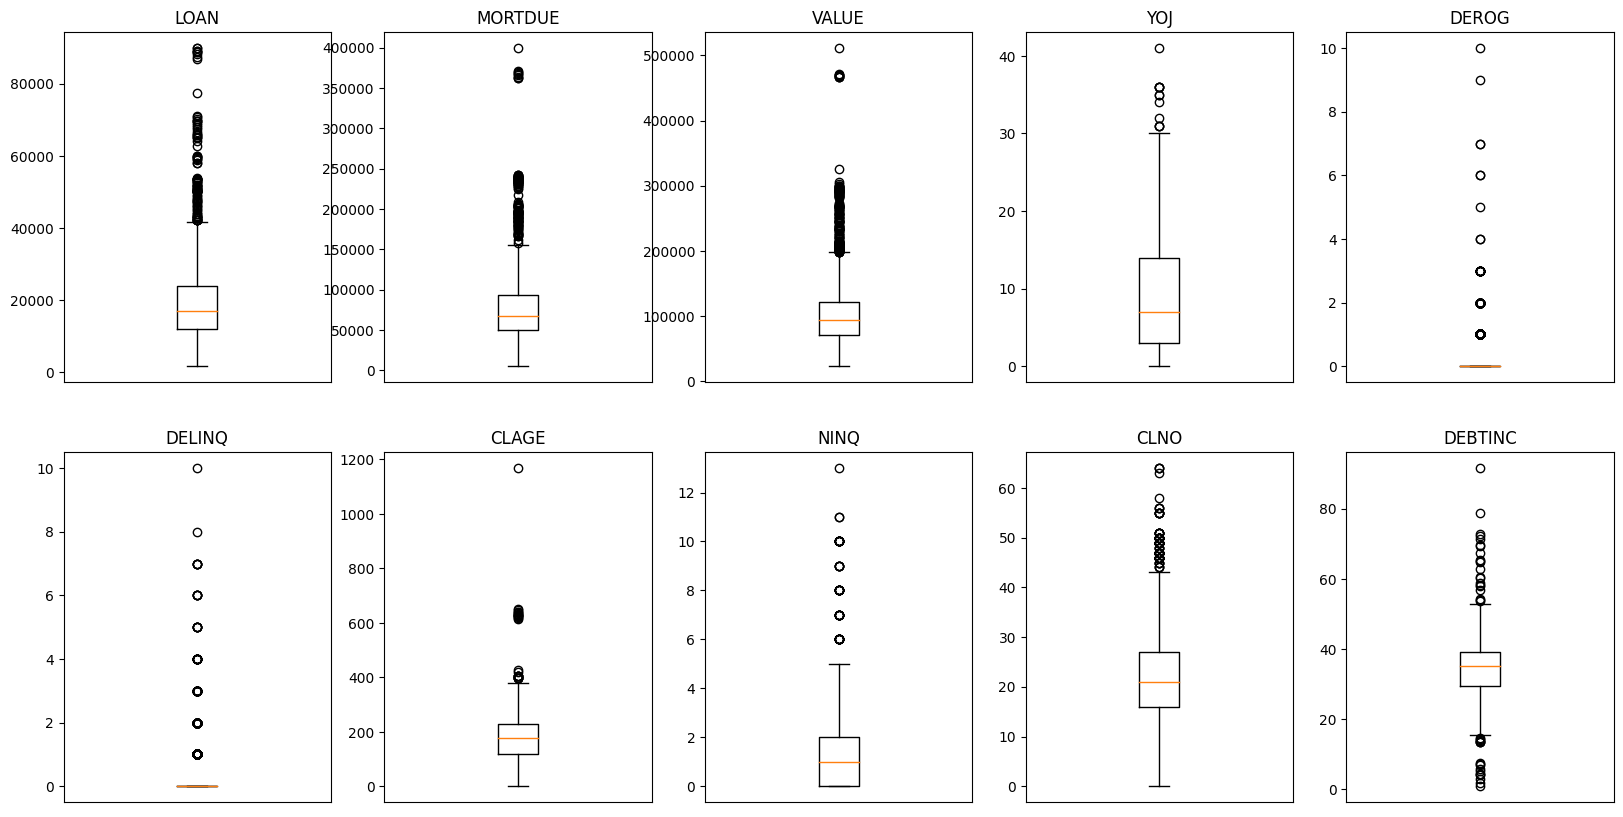

In [14]:
show_outlier(x_train)

In [10]:
print("Train:",x_train.shape)
print("Test:",x_test.shape)

Train: (4768, 12)
Test: (1192, 12)


In [11]:
y_train.value_counts()

0    3817
1     951
Name: BAD, dtype: int64

In [12]:
y_test.value_counts()   

0    954
1    238
Name: BAD, dtype: int64

<h3>Distribution of variables on datesets

In [5]:
def distribution_numerical(column):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Vẽ đồ thị histogram và đường KDE cho tập train
    sns.histplot(x_train[column], bins=15, kde=True, ax=axes[0])
    axes[0].set_title(f"Phân phối của {column} trên tập train")
    axes[0].set_ylabel("Tần suất")
    axes[0].set_xlabel(None)
    axes[0].text(0.95, 0.9, f"Skewness: {x_train[column].skew():.2f}", transform=axes[0].transAxes,
                                horizontalalignment='right', fontsize=12, color='red')

    # Vẽ đồ thị histogram và đường KDE cho test
    sns.histplot(x_test[column], bins=15, kde=True, ax=axes[1])
    axes[1].set_title(f"Phân phối của {column} trên tập test")
    axes[1].set_ylabel("Tần suất")
    axes[1].set_xlabel(None)
    axes[1].text(0.95, 0.9, f"Skewness: {x_test[column].skew():.2f}", transform=axes[1].transAxes,
                                horizontalalignment='right', fontsize=12, color='red')

    # Căn chỉnh và hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

In [6]:
def distribution_category(column, data_train, data_test):

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Vẽ biểu đồ cột thứ nhất
    axes[0].barh(data_train.value_counts().keys().astype('str'), data_train.value_counts().values, color='orange', height = .4)
    axes[0].set_title(f"Phân phối của {column} trên tập train")
    axes[0].set_xlabel(None)
    axes[0].set_ylabel("Danh mục")

    # Vẽ biểu đồ cột thứ hai
    axes[1].barh(data_test.value_counts().keys().astype('str'), data_test.value_counts().values, color='orange', height = .4)
    axes[1].set_title(f"Phân phối của {column} trên tập test")
    axes[1].set_xlabel(None)
    axes[1].set_ylabel(None)

    # Đảo ngược trục y
    axes[0].invert_yaxis()
    axes[1].invert_yaxis()

    for i, count in enumerate(data_train.value_counts()):
        axes[0].text(count, i, str(count), ha="left", va="center", fontweight="bold")
    for i, count in enumerate(data_test.value_counts()):
        axes[1].text(count, i, str(count), ha="left", va="center", fontweight="bold")

    # Căn chỉnh và hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

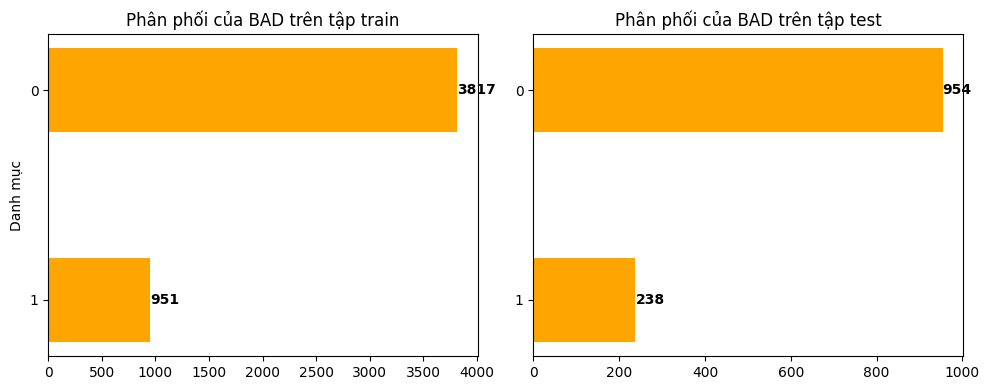

In [15]:
# Distribution of variable "BAD" on train and test
distribution_category("BAD", y_train, y_test)

# Class 0 accounts 80%
# Class 1 accounts 20%

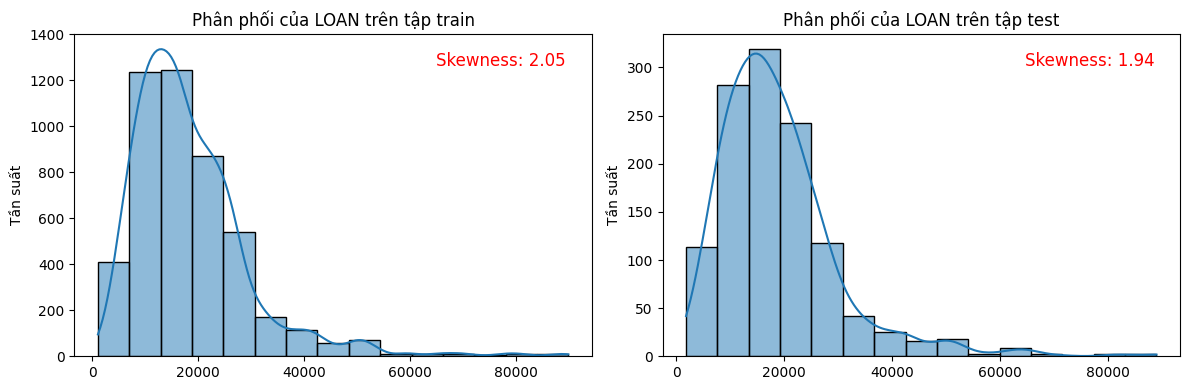

In [16]:
# Distribution of variable "LOAN" on train and test 

distribution_numerical("LOAN")

# Density between 10000-30000 is high

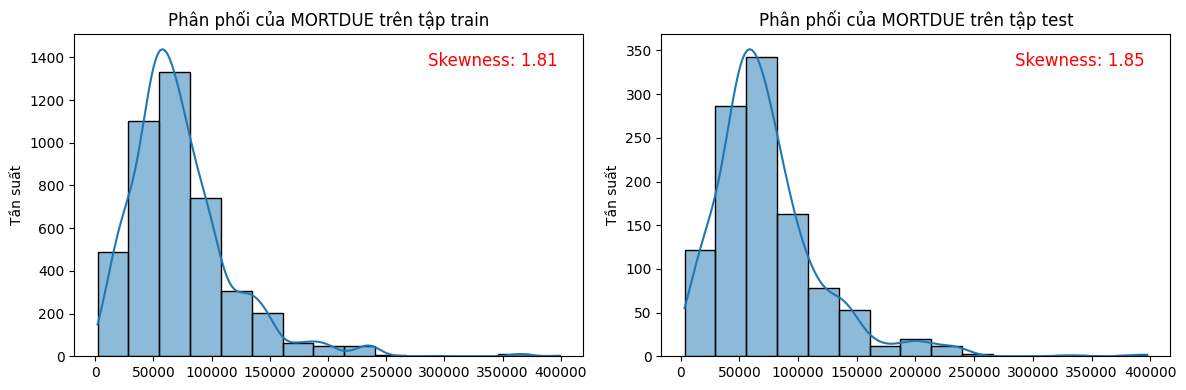

In [17]:
# Distribution of variable "MORTDUE"

distribution_numerical("MORTDUE")

# Density between 40000-100000 is high

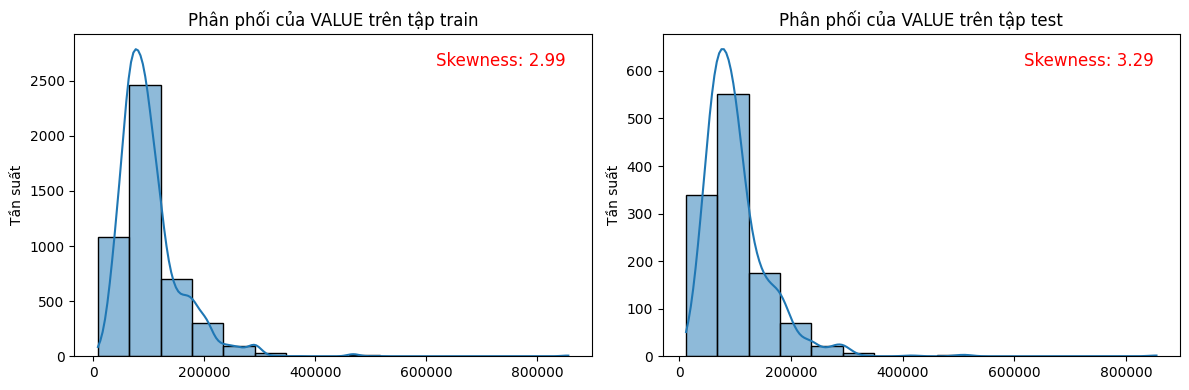

In [18]:
# Distribution of variable "VALUE"

distribution_numerical("VALUE")

# Density between 50000-150000 is high

In [15]:
def distribution_category_(column, data_train, data_test):

    fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

    # Vẽ biểu đồ cột thứ nhất
    axes[0].barh(data_train.value_counts().keys().astype('str'), data_train.value_counts().values, color='orange', height = .4)
    axes[0].set_title(f"Phân phối của {column} trên tập train")
    axes[0].set_xlabel(None)
    axes[0].set_ylabel("Danh mục")

    # Vẽ biểu đồ cột thứ hai
    axes[1].barh(data_test.value_counts().keys().astype('str'), data_test.value_counts().values, color='orange', height = .4)
    axes[1].set_title(f"Phân phối của {column} trên tập test")
    axes[1].set_xlabel(None)
    axes[1].set_ylabel(None)

    # Đảo ngược trục y
    axes[0].invert_yaxis()
    axes[1].invert_yaxis()

    for i, count in enumerate(data_train.value_counts()):
        axes[0].text(count, i, str(count), ha="left", va="center", fontweight="bold")
    for i, count in enumerate(data_test.value_counts()):
        axes[1].text(count, i, str(count), ha="left", va="center", fontweight="bold")

    # Căn chỉnh và hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

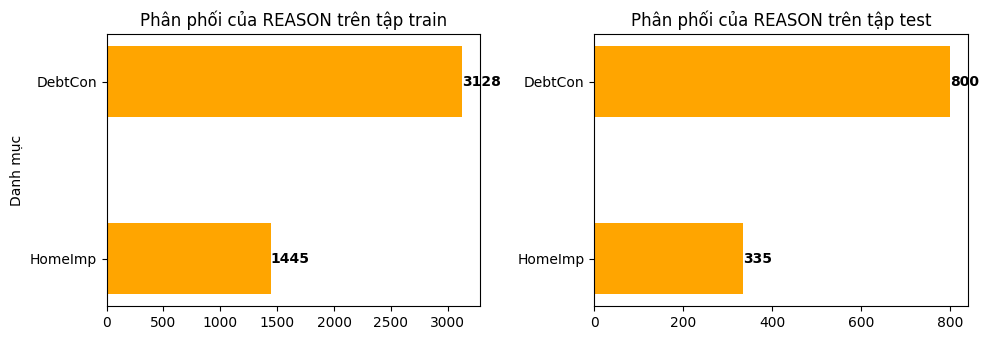

In [16]:
# Distribution of variable "REASON"

distribution_category_("REASON", x_train["REASON"], x_test["REASON"])

# Value DebtCon accounts 70%
# Value HomeImp accounts 30%
# This feature must be converted to digital form to be used

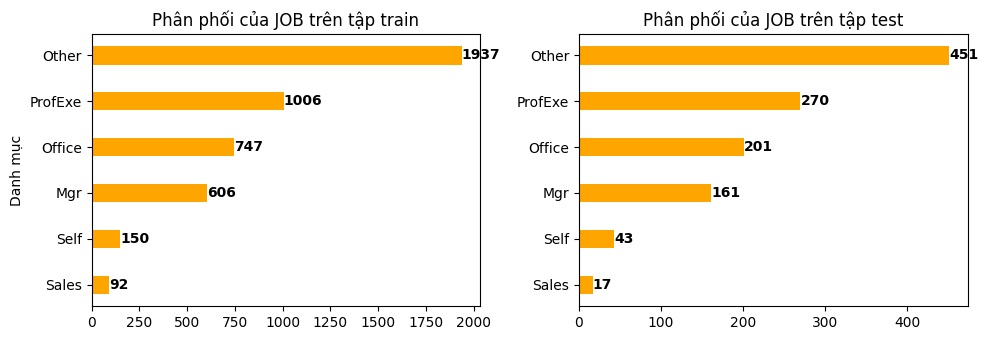

In [17]:
# Distribution of variable "JOB"

distribution_category_("JOB", x_train["JOB"], x_test["JOB"])

# This feature must be converted to digital form to be used

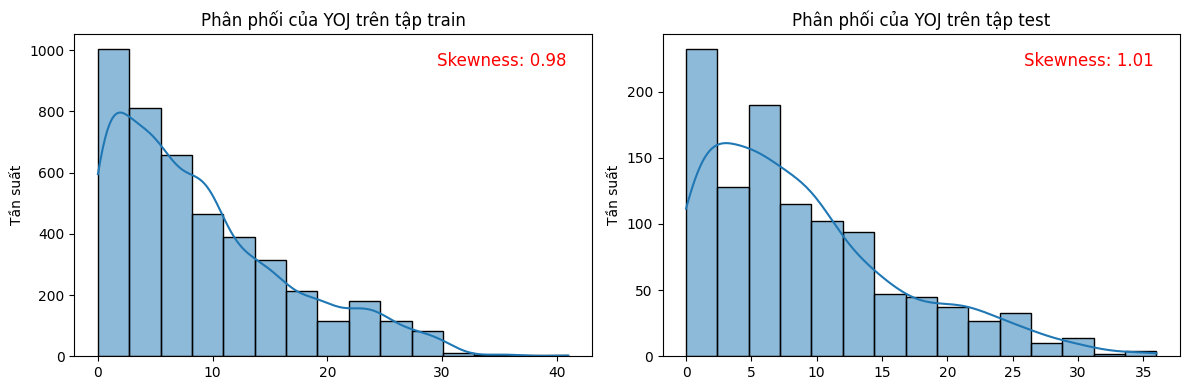

In [21]:
# Distribution of variable "YOJ"

distribution_numerical("YOJ")

# This is very skewed. It would be better if we modify this variable to decrease the skewness.

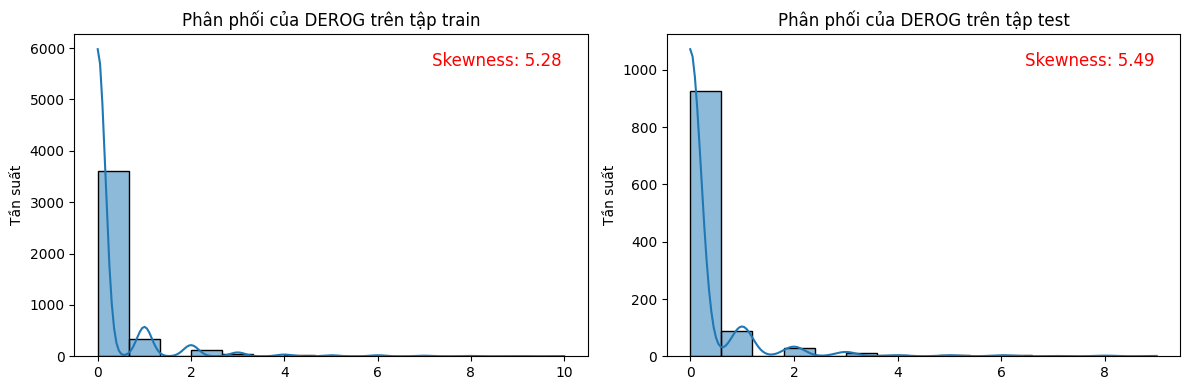

In [18]:
# Distribution of variable "DEROG"

distribution_numerical("DEROG")

# This feature must be converted to digital form to be used

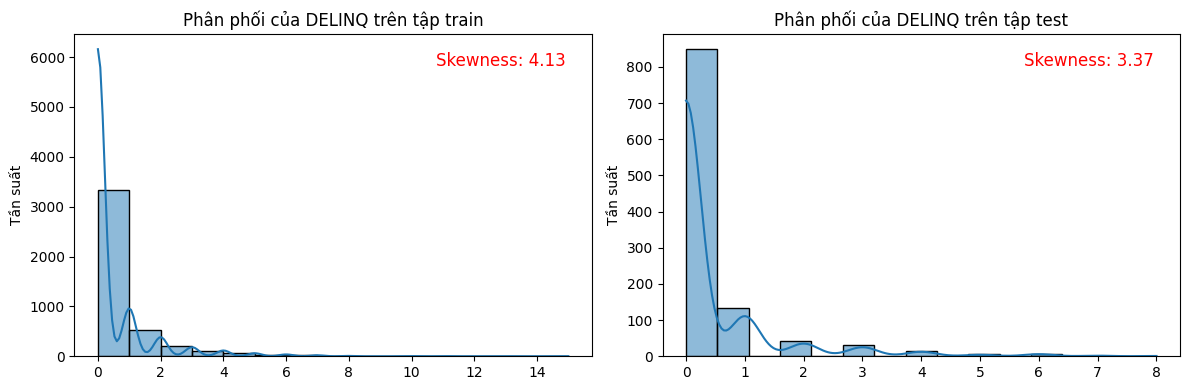

In [19]:
# Distribution of variable "DELINQ"

distribution_numerical("DELINQ")

# This feature must be converted to digital form to be used

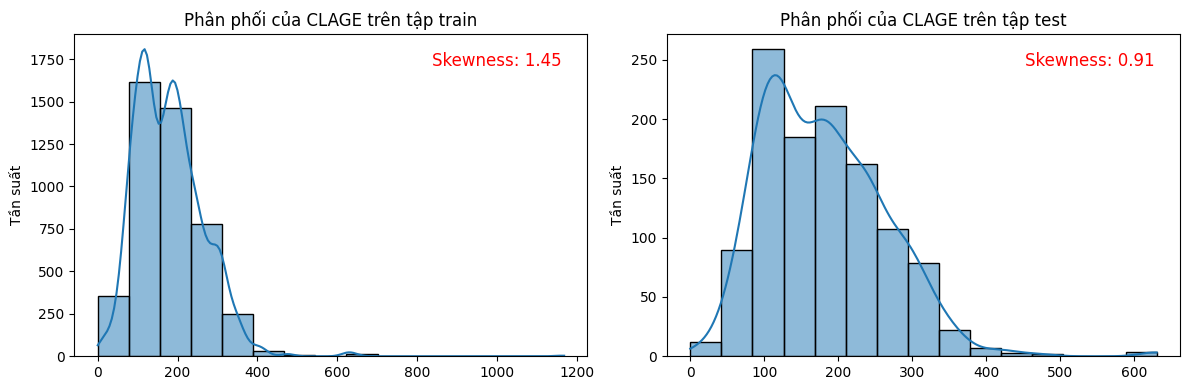

In [24]:
# Distribution of variable "CLAGE"

distribution_numerical("CLAGE")

# Density is high around 100-300

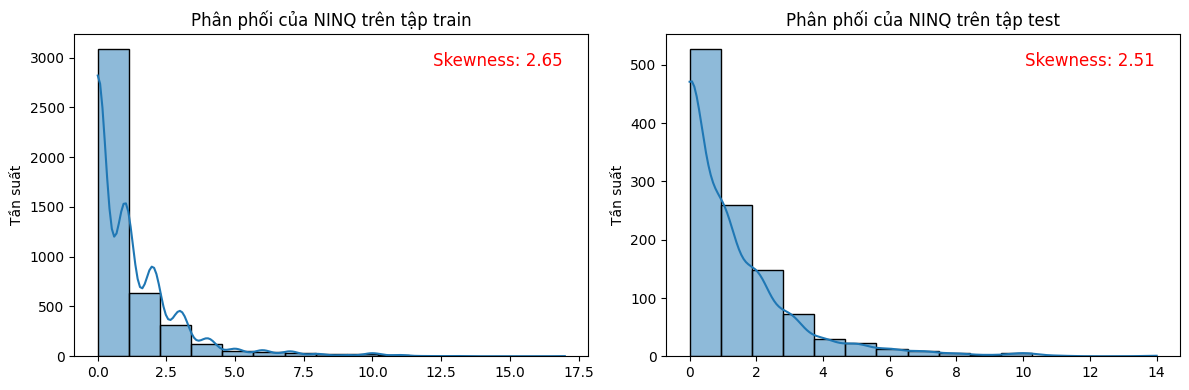

In [20]:
# Distribution of variable "NINQ"

distribution_numerical("NINQ")

# This feature must be converted to digital form to be used

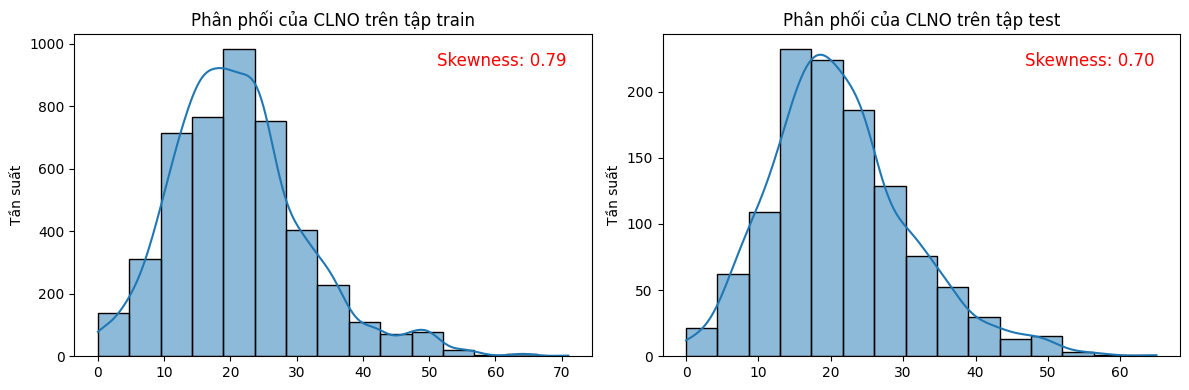

In [26]:
# Distribution of variable "CLNO"

distribution_numerical("CLNO")

# This distribution looks good

In [27]:
print(x_train["CLNO"].value_counts())
print(x_test["CLNO"].value_counts())

16.0    243
19.0    233
24.0    211
23.0    200
20.0    186
       ... 
53.0      2
65.0      2
58.0      2
57.0      1
63.0      1
Name: CLNO, Length: 62, dtype: int64
19.0    74
16.0    73
23.0    59
21.0    55
24.0    53
18.0    50
20.0    45
25.0    45
26.0    42
13.0    41
17.0    41
15.0    39
14.0    38
12.0    34
30.0    29
22.0    29
9.0     28
32.0    28
10.0    26
7.0     21
29.0    21
11.0    21
31.0    21
8.0     19
27.0    19
36.0    18
28.0    18
34.0    16
35.0    15
6.0     13
42.0    12
33.0    11
37.0    10
38.0     9
5.0      9
0.0      9
39.0     7
4.0      6
50.0     5
45.0     5
49.0     5
43.0     5
46.0     4
2.0      4
41.0     3
40.0     3
55.0     3
47.0     3
48.0     3
51.0     2
44.0     1
65.0     1
58.0     1
3.0      1
1.0      1
Name: CLNO, dtype: int64


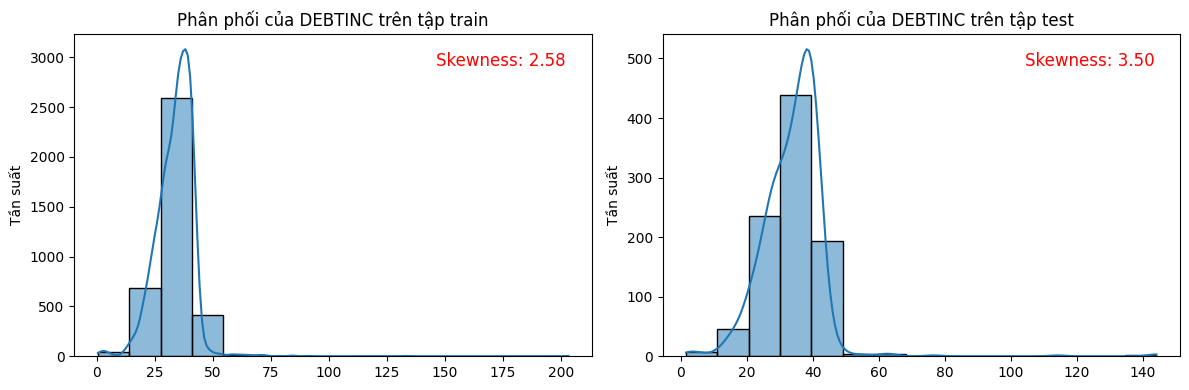

In [28]:
# Distribution of variable "DEBTINC"

distribution_numerical("DEBTINC")

# # Density is high around 20-50

<p>Kết luận: Qua sự phân bố của các trường có thể thấy rằng: </p>
<p>+ Hầu như các trường dữ liệu dạng numeric đều không theo phân phối chuẩn</p>
<p>+ Các trường dữ liệu dạng category đều có sự chênh lệch đang kể về sự phân phối của các giá trị</p>
<p>LOAN: Cột 'LOAN' dường như bị lệch phải (skewness = 2.05 và skewness = 1.94) trên cả tập train và tập test.</p>
<p>MORTDUE: Cột “MORTDUE” bị lệch sang phải (skewness = 1.81 và skewness = 1.85) trên cả tập train và tập test.</p>
<p>VALUE: Cột 'VALUE' bị lệch hẳn về bên phải (skewness = 2.99 và skewness = 3.29) trên cả tập train và tập test.</p>
<p>YOJ: Cột 'YOJ' dường như bị lệch về bên phải (skewness = 0.98 và skewness = 1.01) trên cả tập train và tập test.</p>
<p>CLAGE: Cột “CLAGE” dường như bị lệch sang phải (skewness = 1.45 và skewness = 0.91) trên cả tập train và tập test.</p>
<p>CLNO: Cột “CLAGE” dường như bị lệch sang phải (skewness = 0.79 và skewness = 0.7) trên cả tập train và tập test.</p>
<p>DEBTINC: Cột 'DEBTINC' bị lệch hẳn sang phải trên cả tập train và test.</p>


<h3>Correlation between variables

C:\Users\thang\AppData\Local\Temp\ipykernel_22980\2896070213.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = round(data_corr.corr(),2)


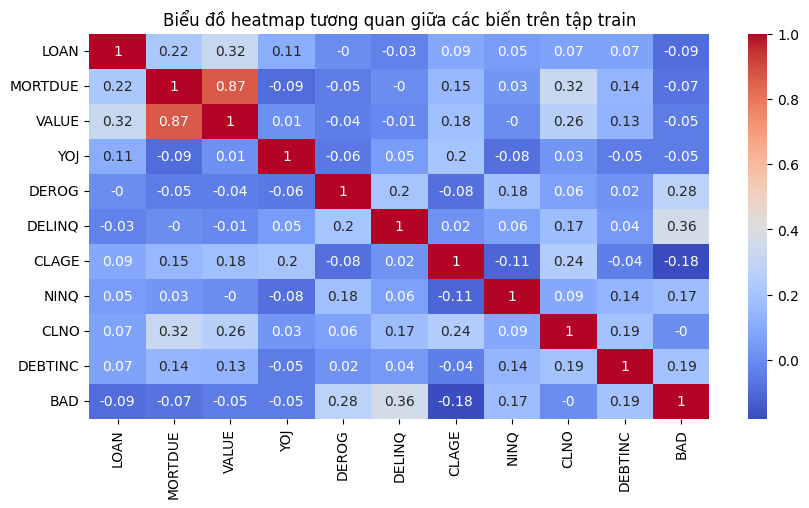

In [29]:
data_corr = x_train.copy()
data_corr["BAD"] = y_train

plt.figure(figsize=(10,5))
# Tạo ma trận tương quan
corr_matrix = round(data_corr.corr(),2)

# Vẽ biểu đồ heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Tùy chỉnh các thông số trên biểu đồ
plt.title("Biểu đồ heatmap tương quan giữa các biến trên tập train")

# Hiển thị biểu đồ
plt.show()

<h3>Relationship between the variable and the predicted variable

In [30]:
def relationship_variable_with_target(data):
    # Create subplots for bar plots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
    fig.suptitle("Relationships between 'BAD' and Different Features", fontsize=16)

    # Bar plot for 'REASON'
    REASON=pd.crosstab(data['REASON'],data['BAD'])
    REASON.div(REASON.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='REASON vs BAD', ax = axes[0,0])

    # Bar plot for 'JOB'
    JOB=pd.crosstab(data['JOB'],data['BAD'])
    JOB.div(JOB.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='JOB vs BAD', ax = axes[0,1])

    # Bar plot for 'DEROG'
    DEROG=pd.crosstab(data['DEROG'],data['BAD'])
    DEROG.div(DEROG.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='DEROG vs BAD', ax = axes[1,0])

    # Bar plot for 'DELINQ'
    DELINQ=pd.crosstab(data['DELINQ'],data['BAD'])
    DELINQ.div(DELINQ.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='DELINQ vs BAD', ax = axes[1,1])

    # Bar plot for 'NINQ'
    NINQ=pd.crosstab(data['NINQ'],data['BAD'])
    NINQ.div(NINQ.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='NINQ vs BAD', ax = axes[2,0])

    # Bar plot for 'DEBTINC'
    bins=[0,40,100,204] 
    group=['Low','Average','High'] 
    dfWithBin = pd.DataFrame()
    dfWithBin['DEBTINC_bin']=pd.cut(data['DEBTINC'],bins,labels=group)
    LOAN_bin=pd.crosstab(dfWithBin['DEBTINC_bin'],data['BAD'])
    LOAN_bin.div(LOAN_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True,title='DEBTINC vs BAD', ax = axes[2,1])
    plt.xlabel('DEBTINC')

    # Adjust layout and display plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

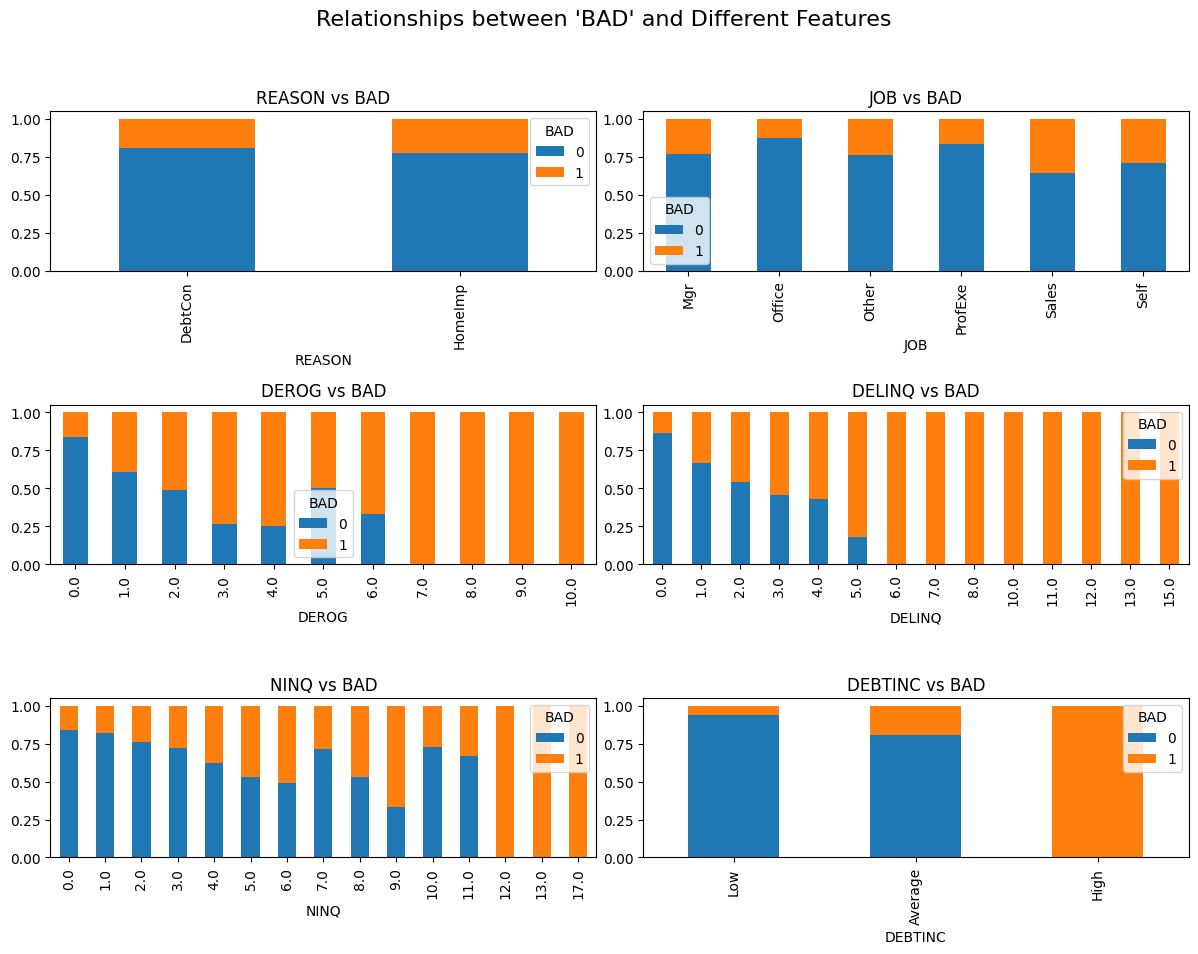

In [31]:
relationship_variable_with_target(data_corr)

<h5>Nhận xét: Đồ thị bên trên biểu diễn sự phụ thuộc của biến dự đoán vào các biến có tính tương quan cao với biến dự đoán: REASON, JOB, DEROG, DELINQ, NINQ, DEBTINC.</h5>
<p>+ Tỉ lệ vỡ nợ do HomeImp (sửa sang nhà cửa) cao hơn tỉ lệ vỡ nợ do DebtCon (vay ghép nợ)
<p>+ Tỉ lệ vỡ nợ do làm công việc Sales cao nhất và tỉ lệ vỡ nợ khi làm các công việc khác là thấp nhất
<p>+ Với số lượng báo cáo vỡ nợ càng nhiều thì khả năng vỡ nợ càng lớn. Và khi số lượng báo cáo vỡ nợ đạt ngưỡng 7 báo cáo trở nên thì khả năng vỡ nợ có thể lên tới 100%
<p>+ Với số hạn mức tín dụng quá hạn càng nhiều thì khả năng vỡ nợ càng lớn. Và khi số hạn mức tín dụng quá hạn đạt ngưỡng 6 trở lên thì khả năng vỡ nợ có thể lên tới 100%
<p>+ Với số lượng yêu cầu tín dụng càng nhiều thì dường như khả năng vỡ nợ càng lớn. Và khi số lượng yêu cầu tín dụng đạt ngưỡng 12 trở lên thì khả năng vỡ nợ có thể lên tới 100%
<p>+ Tỉ lệ (nợ/thu nhập) càng lớn, tức là số tiền nợ hàng tháng phải trả quá cao so với mức lương thu nhập thì khả năng xảy ra vỡ nợ càng cao. Và nếu tỉ lệ này vượt quá 100% thì khả năng vỡ nợ gần như là 100%

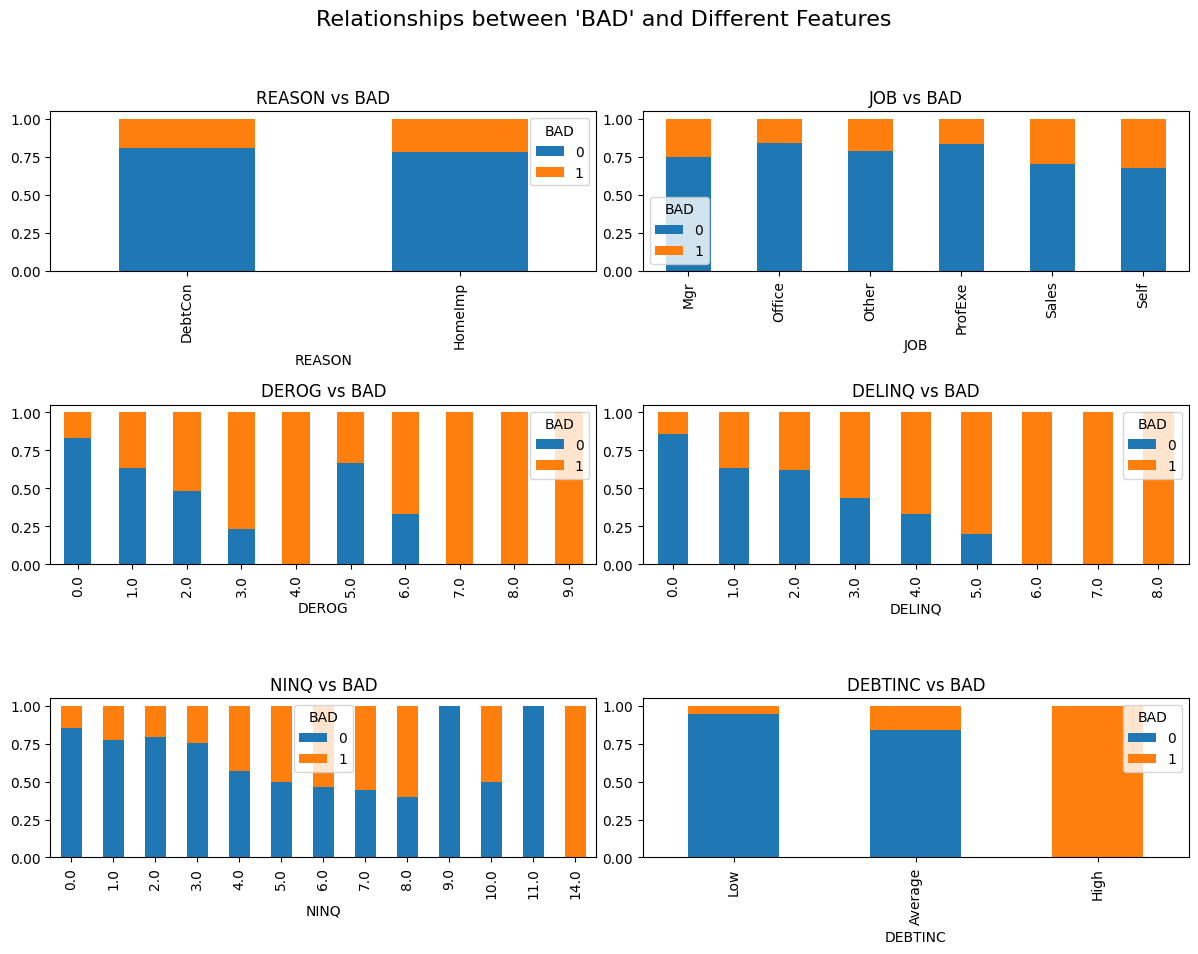

In [32]:
data_corr_test = x_test.copy()
data_corr_test["BAD"] = y_test
relationship_variable_with_target(data_corr_test)

<h5>Kết luận: Với tập test thì dường như những kết luận đều giống trên tập train.</h5>

<h3>Data Preprocessing</h3>

In [33]:
print("Data duplicated on train dataset: ", x_train.duplicated().any()) 
print("Data duplicated on test dataset: ", x_test.duplicated().any()) 

Data duplicated on train dataset:  False
Data duplicated on test dataset:  False


In [34]:
# Kiểm tra xem có bao nhiêu giá trị Nan trong mỗi trường dữ liệu
print("Số giá trị null trong mỗi trường dữ liệu trên tập train:")
print(x_train.isna().sum(), "\n")
print("Số giá trị null trong mỗi trường dữ liệu trên tập test:")
print(x_test.isna().sum())

Số giá trị null trong mỗi trường dữ liệu trên tập train:
LOAN          0
MORTDUE     421
VALUE        89
REASON      195
JOB         230
YOJ         403
DEROG       588
DELINQ      472
CLAGE       259
NINQ        414
CLNO        184
DEBTINC    1005
dtype: int64 

Số giá trị null trong mỗi trường dữ liệu trên tập test:
LOAN         0
MORTDUE     97
VALUE       23
REASON      57
JOB         49
YOJ        112
DEROG      120
DELINQ     108
CLAGE       49
NINQ        96
CLNO        38
DEBTINC    262
dtype: int64


In [35]:
# Tỉ lệ giá trị Nan theo % của các thuộc tính
print("Tỉ lệ giá trị Nan trên tập train:")
print((x_train.isnull().sum()/len(x_train)*100).sort_values())
print("Tỉ lệ giá trị Nan trên tập test:")
print((x_test.isnull().sum()/len(x_test)*100).sort_values())

Tỉ lệ giá trị Nan trên tập train:
LOAN        0.000000
VALUE       1.866611
CLNO        3.859060
REASON      4.089765
JOB         4.823826
CLAGE       5.432047
YOJ         8.452181
NINQ        8.682886
MORTDUE     8.829698
DELINQ      9.899329
DEROG      12.332215
DEBTINC    21.078020
dtype: float64
Tỉ lệ giá trị Nan trên tập test:
LOAN        0.000000
VALUE       1.929530
CLNO        3.187919
JOB         4.110738
CLAGE       4.110738
REASON      4.781879
NINQ        8.053691
MORTDUE     8.137584
DELINQ      9.060403
YOJ         9.395973
DEROG      10.067114
DEBTINC    21.979866
dtype: float64


<p>Quan sát: 
<p>+ Ngoại trừ BAD và LOAN thì tất cả các trường khác đều có những giá trị chưa được khai báo.
<p>+ 'DEBTINC' có tỷ lệ giá trị bị thiếu cao nhất, khoảng 21%. Điều này cho thấy rằng một phần đáng kể dữ liệu bị thiếu cho tính năng này.
<p>+ Các cột 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ' và 'NINQ' có tỷ lệ phần trăm giá trị bị thiếu tương đối cao,dao động từ khoảng 8% đến 12%.
<p>+ Các cột 'REASON', 'JOB', 'CLAGE' và 'CLNO' có tỷ lệ phần trăm giá trị bị thiếu vừa phải, dao động từ khoảng 3% đến 5%.

<p>==>Tỷ lệ phần trăm giá trị bị thiếu có thể đưa ra ý tưởng về chất lượng dữ liệu và những thách thức tiềm ẩn trong việc lập mô hình. Các cột có tỷ lệ phần trăm giá trị bị thiếu cao có thể yêu cầu xử lý cẩn thận trong quá trình tiền xử lý.

<p>Chúng ta có thể xử lý các giá trị bị thiếu theo những cách như sau:
<p>+ Đối với cột numeric có thể sử dụng giá trị mean, median or một giá trị khác thay thế.</p>
<p>+ Đối với cột category có thể sử dụng giá trị xuất hiện nhiều nhất or một giá trị khác thay thế.</p>

In [36]:
x_train.head()

LOAN   MORTDUE     VALUE   REASON      JOB  YOJ  DEROG  DELINQ  \
609    7700  70451.00   81862.0  DebtCon    Sales  3.0    0.0     0.0   
4015  21000  48735.00   71694.0  DebtCon    Other  8.0    0.0     0.0   
1591  11500  63136.00   81099.0  DebtCon    Other  3.0    NaN     NaN   
1127   9900  55342.00   72357.0  DebtCon      Mgr  7.0    NaN     3.0   
920    9000  47350.86  105000.0  DebtCon  ProfExe  6.0    0.0     1.0   

           CLAGE  NINQ  CLNO    DEBTINC  
609   141.268671   0.0  31.0  31.681943  
4015   48.498971   3.0  10.0  32.921401  
1591  149.064745   NaN  35.0  28.975940  
1127  111.998855   1.0  11.0  39.870340  
920   227.266667   0.0  10.0        NaN

In [5]:
# Hàm thay thế các giá trị Nan trong các trường dữ liệu
def inplace_nan_1(x, y, REASON_OTHERS):
    for column in x.columns[1:]:
        if x[column].dtype == 'object':
            if REASON_OTHERS == True and column == 'REASON':
                # Thay thế các giá trị Nan trong trường "REASON" với giá trị "Other reason"
                x.fillna("Other Reason")
            else:
                # Với record có target là 0 sẽ fillna với giá trị xuất hiện nhiều nhất của các record có target = 0
                # Với record có target là 1 sẽ fillna với giá trị xuất hiện nhiều nhất của các record có target = 1
                x.loc[(x[column].isna()) & (y == 0), column] = x[y == 0][column].value_counts().idxmax()
                x.loc[(x[column].isna()) & (y == 1), column] = x[y == 1][column].value_counts().idxmax()
            
        else:
            # Vì trong các trường dữ liệu số đều có giá trị outlier nên sẽ thay thế bởi giá trị median
            # Với record có target là 0 sẽ fillna với giá trị median của các record có target = 0
            # Với record có target là 1 sẽ fillna với giá trị median của các record có target = 1
            x.loc[(x[column].isna()) & (y == 0), column] = round(x[y == 0][column].median(), 0)
            x.loc[(x[column].isna()) & (y == 1), column] = round(x[y == 1][column].median(), 0)

def inplace_nan_2(x, y):
    # Combine X and Y into a single DataFrame
    data = pd.concat([x, y], axis=1)
    # Numerosity Reduction, with a threshold of 3 null values
    data.dropna(axis=0,thresh=3,inplace=True)
    # Filling the rest of the null values using interpolated values, mode and median
    data.fillna(value=data.interpolate(),inplace=True)

    for column in data.columns[data.isnull().any()].tolist():
        if data[column].dtype == 'object':
            # Nếu trường có giá trị phân loại thì thay bởi giá trị xuất hiện nhiều nhất
            data[column].fillna(data[column].mode().iloc[0], inplace=True)
        else:
            # Ngược lại thay bởi giá trị median
            data[column].fillna(data[column].median(), inplace=True)

    # Split back into X and Y
    x = data.iloc[:, :len(x.columns)]
    y = data.iloc[:, len(x.columns):]

    return x, y
            
def inplace_nan_3(x, y):
    # Với trường dữ liệu dạng category và trường DEROG, DELINQ thì điền các giá trị Null bằng giá trị xuất hiện nhiều nhất
    x["REASON"].fillna(value = "DebtCon",inplace = True)
    x["JOB"].fillna(value = "Other",inplace = True)
    x["DEROG"].fillna(value=0,inplace=True)
    x["DELINQ"].fillna(value=0,inplace=True)
    # Với các trường dữ liệu còn lại điền bằng giá trị median
    x.fillna(value=x.mean(),inplace=True)

def inplace_nan_4(df):
    # Sử dụng get_dummies để tách các giá trị trong trường category thành các trường dữ liệu mới
    df=pd.get_dummies(df, columns=['REASON','JOB'])
    # Loại bỏ trường dữ liệu DEBTINC do chứa khá nhiều dữ liệu Null
    df.drop('DEBTINC', axis=1, inplace=True)
    # Loại bỏ bất kì hàng nào có chứa giá trị Null
    df.dropna(axis=0, how='any', inplace=True)
    
    return df
    



<h3>Adjust category data</h3>

In [6]:
def adjust_inconsistent(x, index, save):
    labelEncoder = LabelEncoder()
    for column in x.columns:
        if x[column].dtype == 'object':
            x[column] = labelEncoder.fit_transform(x[column])
    if save:
        pickle.dump(labelEncoder, open(f'./model_df{index}/LabelEncoder.pickle', 'wb'))

<h3>Outlier of each data field</h3>

In [7]:
def show_outlier(df):
    fig, ax = plt.subplots(3,4,figsize=(20,10))
    row = 0
    column = 0
    for name_column in df.columns:
        if df[name_column].dtype == 'object':
            ax[row, column].bar(list(df[name_column].value_counts().keys()), list(df[name_column].value_counts().values))
            ax[row,column].set_title(name_column)
        else:
            ax[row, column].boxplot(df[name_column])
            ax[row, column].set_xticks([])
            ax[row,column].set_title(name_column)
    
        if column == 3: 
            row += 1
            column = 0
        else:
            column+=1

In [8]:
def remove_outlier_IQR(x, y, columns):
    df = pd.concat([x, y], axis=1)
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = ((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)
    df_final = df[~outlier_mask]

    # Split back into X and Y
    x = df_final.iloc[:, :len(x.columns)]
    y = df_final.iloc[:, len(x.columns):]

    return x, y

<h3>Standardized data</h3>

In [9]:
def preprocess_standard(X, y, index): 

  # Using Standard Scaler, as it might also take care of some outliers
  sscaler = StandardScaler(copy=True, with_mean=True, with_std=True)
  scaled_features = sscaler.fit_transform(X)

  # Standard Scaler retuen a numpy array, convertig it back into a DataFrame, for ease of understanding
  scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
  pickle.dump(sscaler, open(f'./model_df{index}/StandardScaler.pickle', 'wb'))
  return scaled_features_df,y

def preprocess_standard_test(X, y, index):
  scaler = pickle.load(open(f'./model_df{index}/StandardScaler.pickle', 'rb'))
  scaled_features = scaler.transform(X)
  # Standard Scaler retuen a numpy array, convertig it back into a DataFrame, for ease of understanding
  scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
  return scaled_features_df,y
  

def preprocess_min_max(X, y, index):

  # Using MinMaxScaler, as it might also take care of some outliers
  sscaler = MinMaxScaler()
  scaled_features = sscaler.fit_transform(X)

  # MinMax Scaler retuen a numpy array, convertig it back into a DataFrame, for ease of understanding
  scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
  pickle.dump(sscaler, open(f'./model_df{index}/MinMaxScaler.pickle', 'wb'))
  return scaled_features_df,y

def preprocess_min_max_test(X, y, index):
  scaler = pickle.load(open(f'./model_df{index}/MinMaxScaler.pickle', 'rb'))
  scaled_features = scaler.transform(X)
  # MinMax Scaler retuen a numpy array, convertig it back into a DataFrame, for ease of understanding
  scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
  return scaled_features_df,y

<h3>Transfer data to standard distribution

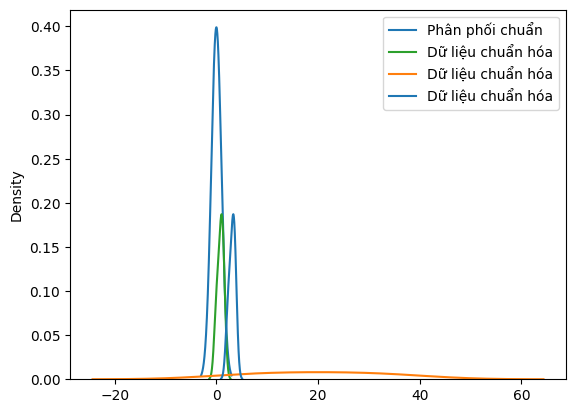

In [52]:
from scipy.stats import norm

def data_norm_log(data, columns):
    transformed_data = data.copy()  # Tạo một bản sao của dữ liệu để tránh thay đổi dữ liệu gốc
    transformed_data[columns] = np.log(transformed_data[columns])
    return transformed_data

# Dữ liệu
data = pd.DataFrame({
    'column1': [10, 20, 30, 40],
    'column2': [5, 15, 25, 35],
    'column3': [1, 2, 3, 4]
})

data1 = data_norm_log(data, ['column1', 'column3'])

data1
x = np.linspace(-3, 3, 1000)
y = norm.pdf(x, 0, 1)

plt.plot(x, y, label='Phân phối chuẩn')
# Vẽ biểu đồ KDE đã chuẩn hóa
sns.kdeplot(data1, label='Dữ liệu chuẩn hóa')

plt.legend()
plt.show()

In [43]:
# Áp dụng hàm np.log() cho cột 'column1' và 'column3'
transformed_data = data_norm_log(data, ['column1', 'column3'])

print(transformed_data)

    column1  column2   column3
0  2.302585        5  0.000000
1  2.995732       15  0.693147
2  3.401197       25  1.098612
3  3.688879       35  1.386294


<h3>Create datasets

In [10]:
def distribution_data(data):
    # Tạo figure và axes với kích thước 3x4
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))

    # Lặp qua từng cột dữ liệu và vẽ biểu đồ KDE trên từng axes
    for i, ax in enumerate(axes.flatten()):
        if i < data.shape[1]:
            sns.kdeplot(data=data.iloc[:, i], ax=ax)
            ax.set_title(data.columns[i])

    # Xoá các axes còn dư thừa
    if i < data.shape[1] - 1:
        for j in range(i+1, data.shape[1]):
            fig.delaxes(axes.flatten()[j])

    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

<p style="color: yellow;">Tạo DF1: Đã loại bỏ các record có nhiều hơn 4 giá trị Nan, sau đó thay thế các giá trị Nan bằng giá trị nội suy. Những giá trị không được thay thế thì:
<p style="color: yellow;">+ Với giá trị phân loại: thay thế bằng giá trị xuất hiện nhiều nhất
<p style="color: yellow;">+ Với giá trị số: thay thế bằng giá trị median
<p style="color: yellow;">Sau đó LabelEncoder những trường chứa giá trị phân loại, thực hiện loại bỏ outlier dựa trên những trường dữ liệu có tính tương quan cao với trường dự đoán
<p style="color: yellow;">Cuối cùng tiến hành chuẩn hóa dữ liệu theo pp StandardScaler or MinMaxScaler

In [11]:
x_train_1, x_test_1, y_train_1, y_test_1 = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

In [12]:
# Thay thế các giá trị Nan
x_train_1, y_train_1 = inplace_nan_2(x_train_1, y_train_1)
x_test_1, y_test_1 = inplace_nan_2(x_test_1, y_test_1)
# Loại bỏ outlier
x_train_1, y_train_1 = remove_outlier_IQR(x_train_1, y_train_1, ["NINQ", "DEBTINC"])
x_test_1, y_test_1 = remove_outlier_IQR(x_test_1, y_test_1, ["NINQ", "DEBTINC"])
# LableEncoder 
adjust_inconsistent(x_train_1, 1, True)
adjust_inconsistent(x_test_1, 1, False)
# Chuẩn hóa dữ liệu theo pp StandardScaler
x_train_1, y_train_1 = preprocess_standard(x_train_1, y_train_1, 1)
x_test_1, y_test_1 = preprocess_standard_test(x_test_1, y_test_1, 1)

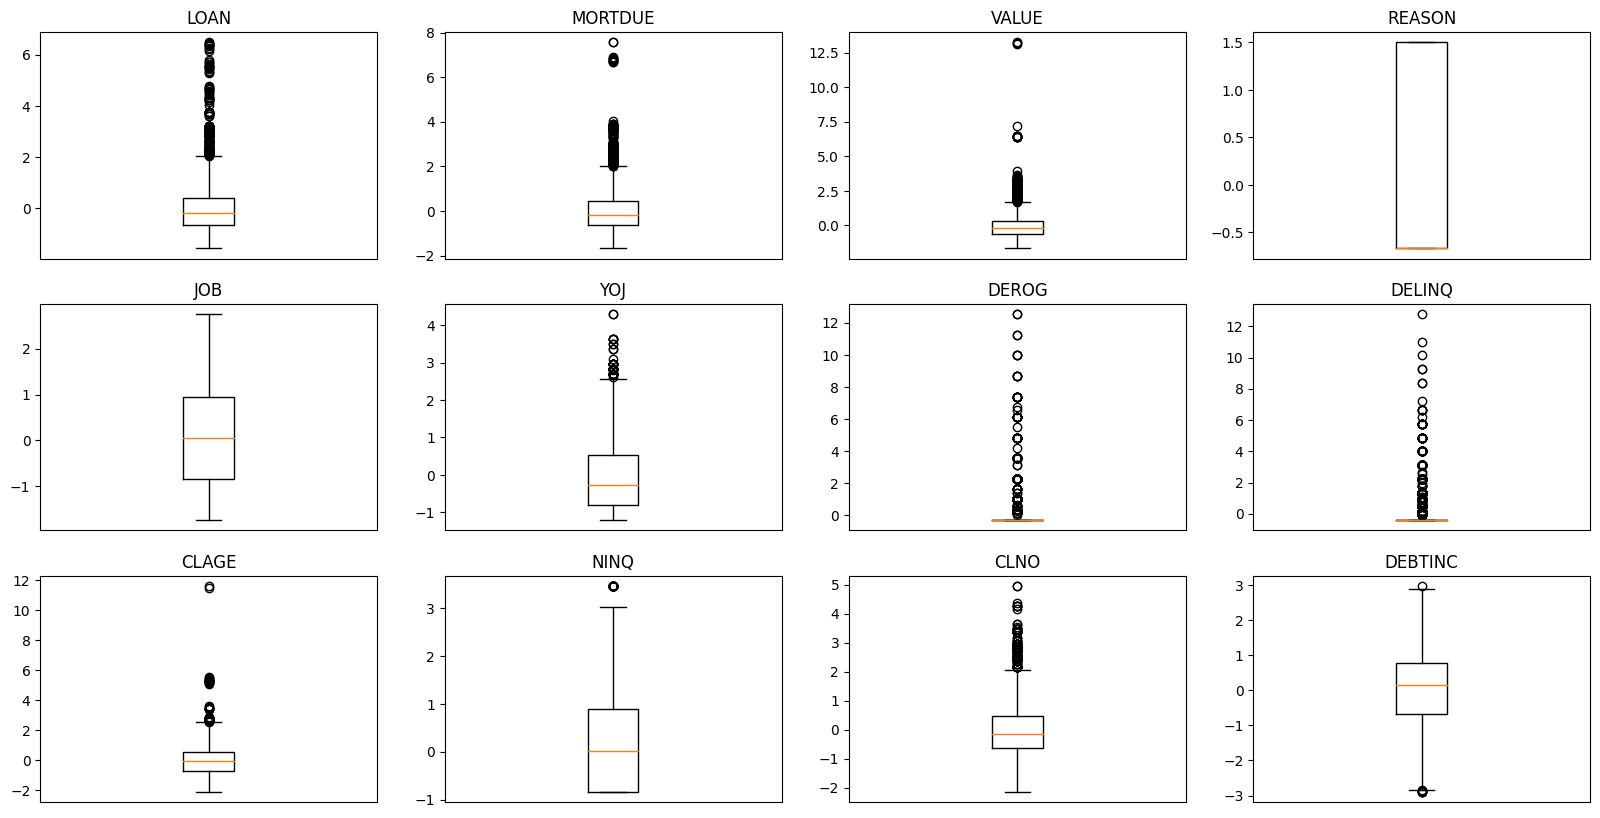

In [139]:
show_outlier(x_train_1)

<p style="color: yellow;">Tạo DF2: Thay thế các giá trị Nan như sau:
<p style="color: yellow;">+ Với giá trị phân loại: thay thế bằng giá trị xuất hiện nhiều nhất ứng với target tương ứng
<p style="color: yellow;">+ Với giá trị số: thay thế bằng giá trị median của các record có target tương ứng
<p style="color: yellow;">Sau đó LabelEncoder những trường chứa giá trị phân loại, thực hiện loại bỏ outlier dựa trên những trường dữ liệu có tính tương quan cao với trường dự đoán
<p style="color: yellow;">Cuối cùng tiến hành chuẩn hóa dữ liệu theo pp StandardScaler or MinMaxScaler

In [13]:
x_train_2, x_test_2, y_train_2, y_test_2 = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

In [14]:
# Thay thế các giá trị Nan
inplace_nan_1(x_train_2, y_train_2, False)
inplace_nan_1(x_test_2, y_test_2, False)
# Loại bỏ outlier
x_train_2, y_train_2 = remove_outlier_IQR(x_train_2, y_train_2, ["NINQ", "DEBTINC"])
x_test_2, y_test_2 = remove_outlier_IQR(x_test_2, y_test_2, ["NINQ", "DEBTINC"])
# LableEncoder 
adjust_inconsistent(x_train_2, 2, True)
adjust_inconsistent(x_test_2, 2, False)
# Chuẩn hóa dữ liệu theo pp StandardScaler
x_train_2, y_train_2 = preprocess_standard(x_train_2, y_train_2, 2)
x_test_2, y_test_2 = preprocess_standard_test(x_test_2, y_test_2, 2)

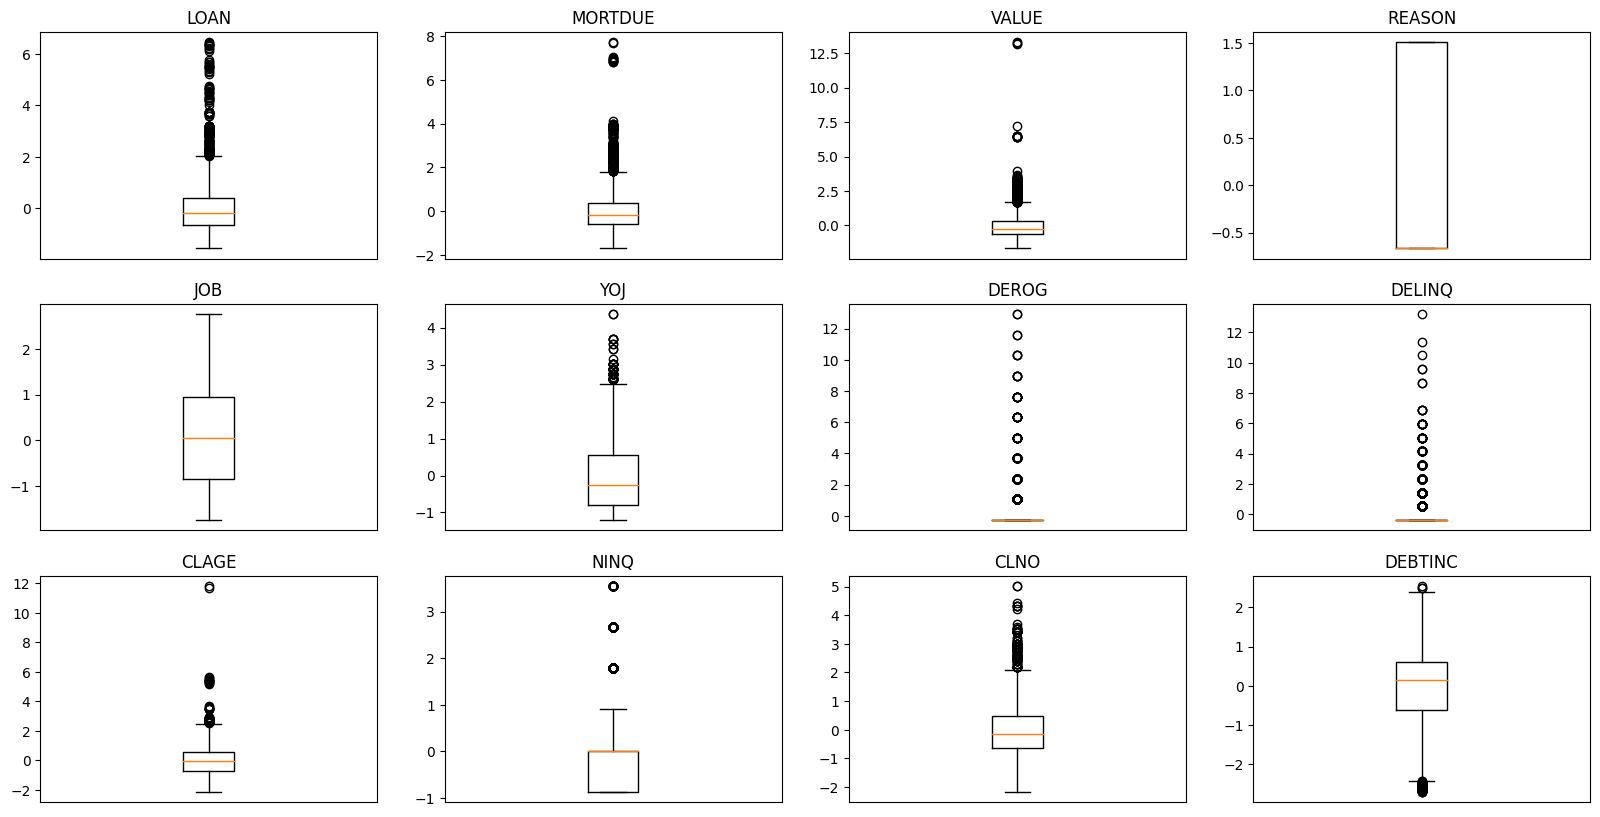

In [142]:
show_outlier(x_train_2)

<p style="color: yellow;">Tạo DF3: Thay thế các giá trị Nan như sau:
<p style="color: yellow;">+ Với giá trị phân loại: thay thế bằng giá trị xuất hiện nhiều nhất ứng với target tương ứng (trừ REASON). Nếu là trường REASON sẽ thay thế bằng giá trị "Other reason"
<p style="color: yellow;">+ Với giá trị số: thay thế bằng giá trị median của các record có target tương ứng
<p style="color: yellow;">Sau đó LabelEncoder những trường chứa giá trị phân loại, thực hiện loại bỏ outlier dựa trên những trường dữ liệu có tính tương quan cao với trường dự đoán
<p style="color: yellow;">Cuối cùng tiến hành chuẩn hóa dữ liệu theo pp StandardScaler or MinMaxScaler

In [15]:
x_train_3, x_test_3, y_train_3, y_test_3 = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

In [16]:
# Thay thế các giá trị Nan
inplace_nan_1(x_train_3, y_train_3, True)
inplace_nan_1(x_test_3, y_test_3, True)
# Loại bỏ outlier
x_train_3, y_train_3 = remove_outlier_IQR(x_train_3, y_train_3, ["NINQ", "DEBTINC"])
x_test_3, y_test_3 = remove_outlier_IQR(x_test_3, y_test_3, ["NINQ", "DEBTINC"])
# LableEncoder 
adjust_inconsistent(x_train_3, 3, True)
adjust_inconsistent(x_test_3, 3, False)
# Chuẩn hóa dữ liệu theo pp StandardScaler
x_train_3, y_train_3 = preprocess_standard(x_train_3, y_train_3, 3)
x_test_3, y_test_3 = preprocess_standard_test(x_test_3, y_test_3, 3)

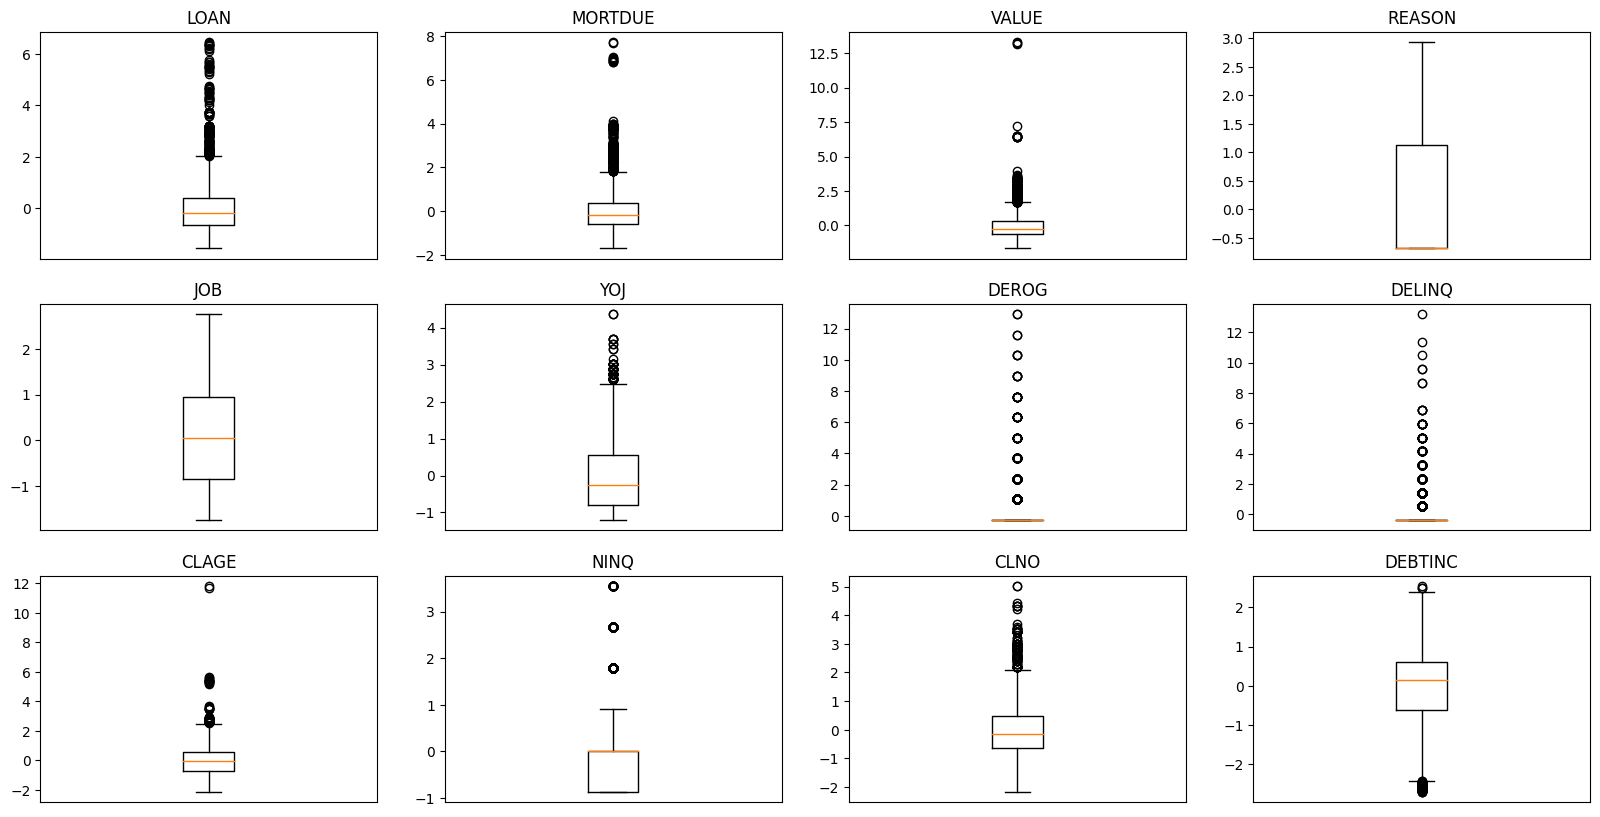

In [145]:
show_outlier(x_train_3)

<p style="color: yellow;">Tạo DF4: Thay thế các giá trị Nan như sau:
<p style="color: yellow;">+ Với giá trị phân loại: thay thế bằng giá trị xuất hiện nhiều nhất
<p style="color: yellow;">+ Với giá trị số: thay thế bằng giá trị mean của trường dữ liệu tương ứng
<p style="color: yellow;">Sau đó LabelEncoder những trường chứa giá trị phân loại, thực hiện loại bỏ outlier dựa trên những trường dữ liệu có tính tương quan cao với trường dự đoán
<p style="color: yellow;">Cuối cùng tiến hành chuẩn hóa dữ liệu theo pp StandardScaler or MinMaxScaler

In [17]:
x_train_4, x_test_4, y_train_4, y_test_4 = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

In [18]:
# Thay thế các giá trị Nan
inplace_nan_3(x_train_4, y_train_4)
inplace_nan_3(x_test_4, y_test_4)
# Loại bỏ outlier
x_train_4, y_train_4 = remove_outlier_IQR(x_train_4, y_train_4, ["NINQ", "DEBTINC"])
x_test_4, y_test_4 = remove_outlier_IQR(x_test_4, y_test_4, ["NINQ", "DEBTINC"])
# LableEncoder 
adjust_inconsistent(x_train_4, 4, True)
adjust_inconsistent(x_test_4, 4, False)
# Chuẩn hóa dữ liệu theo pp StandardScaler
x_train_4, y_train_4 = preprocess_standard(x_train_4, y_train_4, 4)
x_test_4, y_test_4 = preprocess_standard_test(x_test_4, y_test_4, 4)

C:\Users\thang\AppData\Local\Temp\ipykernel_12696\2190502562.py:48: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  x.fillna(value=x.mean(),inplace=True)


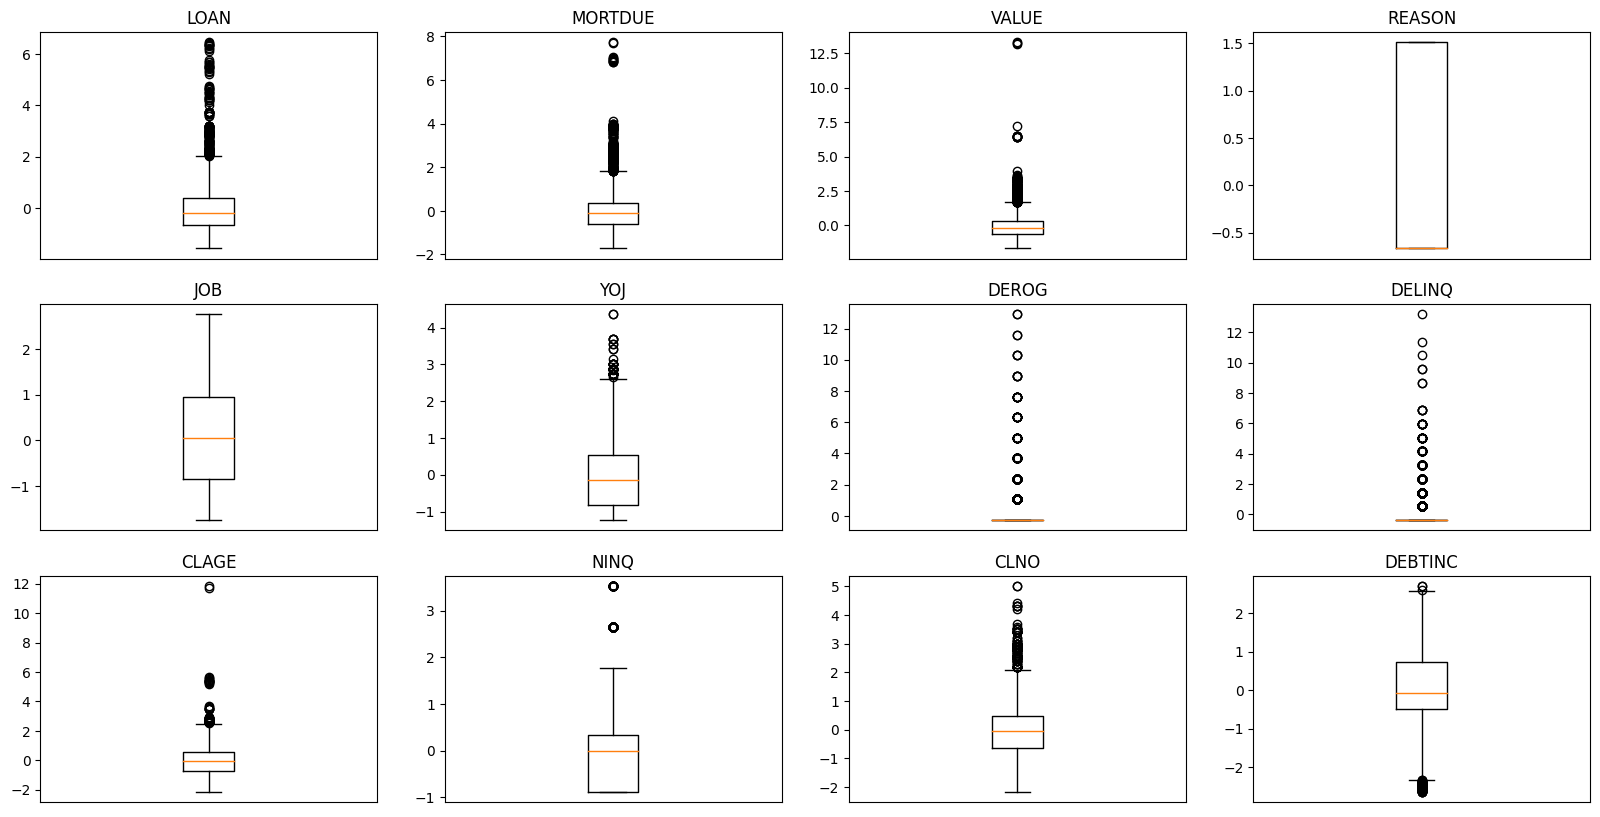

In [148]:
show_outlier(x_train_4)

<p style="color: yellow;">Tạo DF5: Thay thế các giá trị Nan như sau:
<p style="color: yellow;">+ Với giá trị phân loại: thay thế bằng giá trị xuất hiện nhiều nhất
<p style="color: yellow;">+ Với giá trị số: thay thế bằng giá trị mean của trường dữ liệu tương ứng
<p style="color: yellow;">Sau đó loại bỏ trường dữ liệu "MORTDUE"
<p style="color: yellow;">Sau đó LabelEncoder những trường chứa giá trị phân loại, thực hiện loại bỏ outlier dựa trên những trường dữ liệu có tính tương quan cao với trường dự đoán
<p style="color: yellow;">Cuối cùng tiến hành chuẩn hóa dữ liệu theo pp StandardScaler or MinMaxScaler

In [19]:
x_train_5, x_test_5, y_train_5, y_test_5 = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

In [20]:
# Loại bỏ trường dữ liệu MORTDUE
x_train_5.drop(['MORTDUE'], axis=1, inplace=True)
x_test_5.drop(['MORTDUE'], axis=1, inplace=True)
# Thay thế các giá trị Nan
inplace_nan_3(x_train_5, y_train_5)
inplace_nan_3(x_test_5, y_test_5)
# Loại bỏ outlier
x_train_5, y_train_5 = remove_outlier_IQR(x_train_5, y_train_5, ["NINQ", "DEBTINC"])
x_test_5, y_test_5 = remove_outlier_IQR(x_test_5, y_test_5, ["NINQ", "DEBTINC"])
# LableEncoder 
adjust_inconsistent(x_train_5, 5, True)
adjust_inconsistent(x_test_5, 5, False)
# Chuẩn hóa dữ liệu theo pp StandardScaler
x_train_5, y_train_5 = preprocess_standard(x_train_5, y_train_5, 5)
x_test_5, y_test_5 = preprocess_standard_test(x_test_5, y_test_5, 5)

C:\Users\thang\AppData\Local\Temp\ipykernel_12696\2190502562.py:48: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  x.fillna(value=x.mean(),inplace=True)


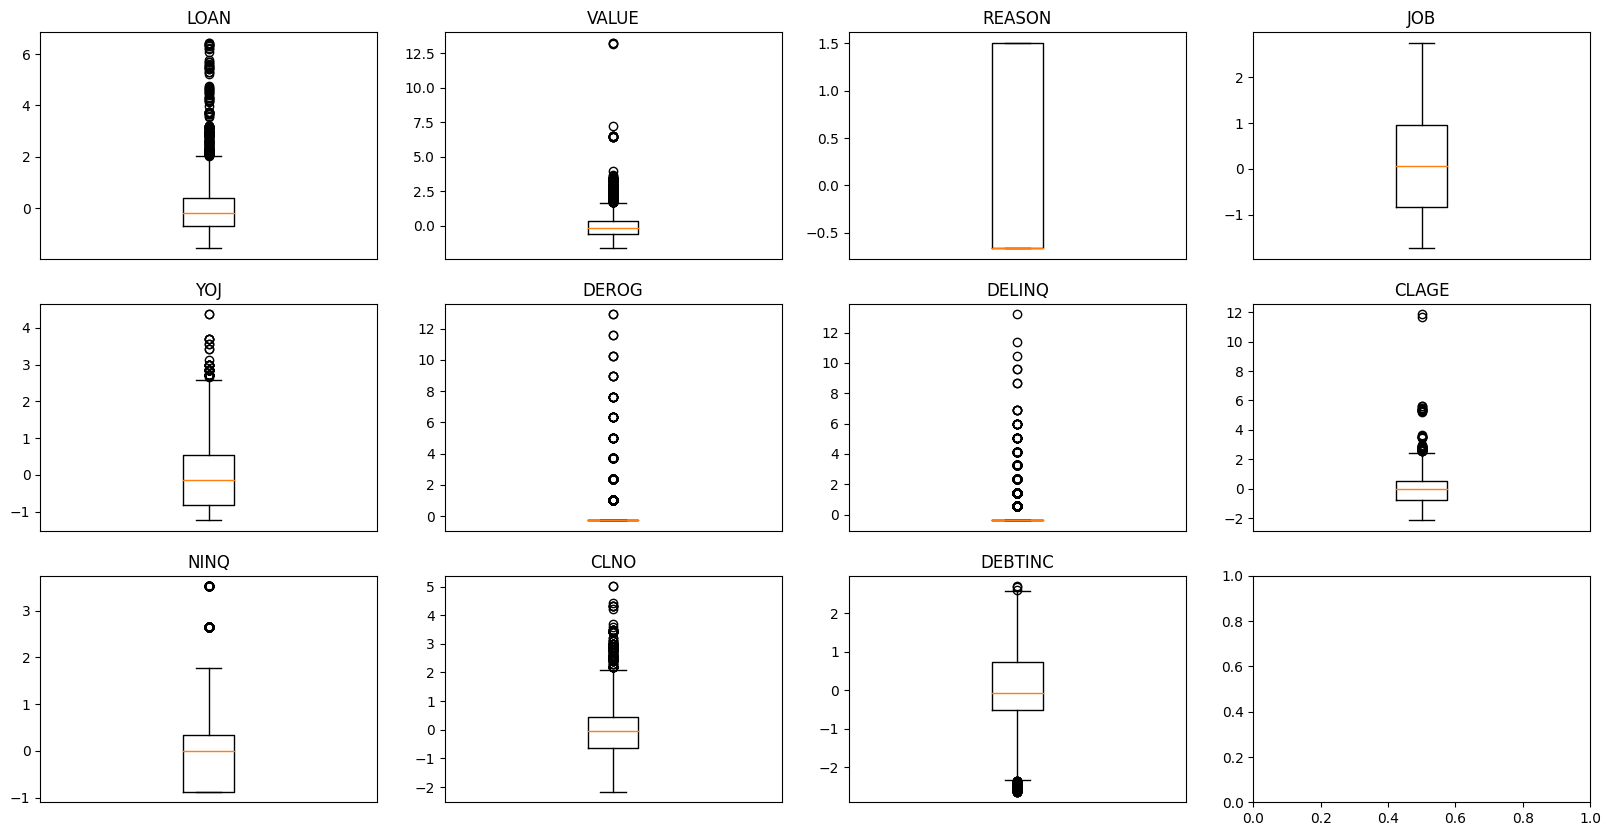

In [151]:
show_outlier(x_train_5)

<p style="color: yellow;">Tạo DF6: Thay thế các giá trị Nan như sau:
<p style="color: yellow;">+ Với giá trị phân loại: thay thế bằng giá trị xuất hiện nhiều nhất
<p style="color: yellow;">+ Với giá trị số: thay thế bằng giá trị mean của trường dữ liệu tương ứng
<p style="color: yellow;">Sau đó LabelEncoder những trường chứa giá trị phân loại, thực hiện loại bỏ outlier dựa trên những trường dữ liệu có tính tương quan cao với trường dự đoán
<p style="color: yellow;">Cuối cùng tiến hành chuẩn hóa dữ liệu theo pp StandardScaler or MinMaxScaler

In [21]:
x_train_6, x_test_6, y_train_6, y_test_6 = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

In [22]:
# Thay thế các giá trị Nan
inplace_nan_3(x_train_6, y_train_6)
inplace_nan_3(x_test_6, y_test_6)
# Loại bỏ outlier
x_train_6, y_train_6 = remove_outlier_IQR(x_train_6, y_train_6, ["NINQ", "DEBTINC"])
x_test_6, y_test_6 = remove_outlier_IQR(x_test_6, y_test_6, ["NINQ", "DEBTINC"])
# LableEncoder 
adjust_inconsistent(x_train_6, 6, True)
adjust_inconsistent(x_test_6, 6, False)
# Đưa các trường dữ liệu về phân phối chuẩn
x_train_6, y_train_6 = preprocess_min_max(x_train_6, y_train_6, 6)
x_test_6, y_test_6 = preprocess_min_max_test(x_test_6, y_test_6, 6)

C:\Users\thang\AppData\Local\Temp\ipykernel_12696\2190502562.py:48: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  x.fillna(value=x.mean(),inplace=True)


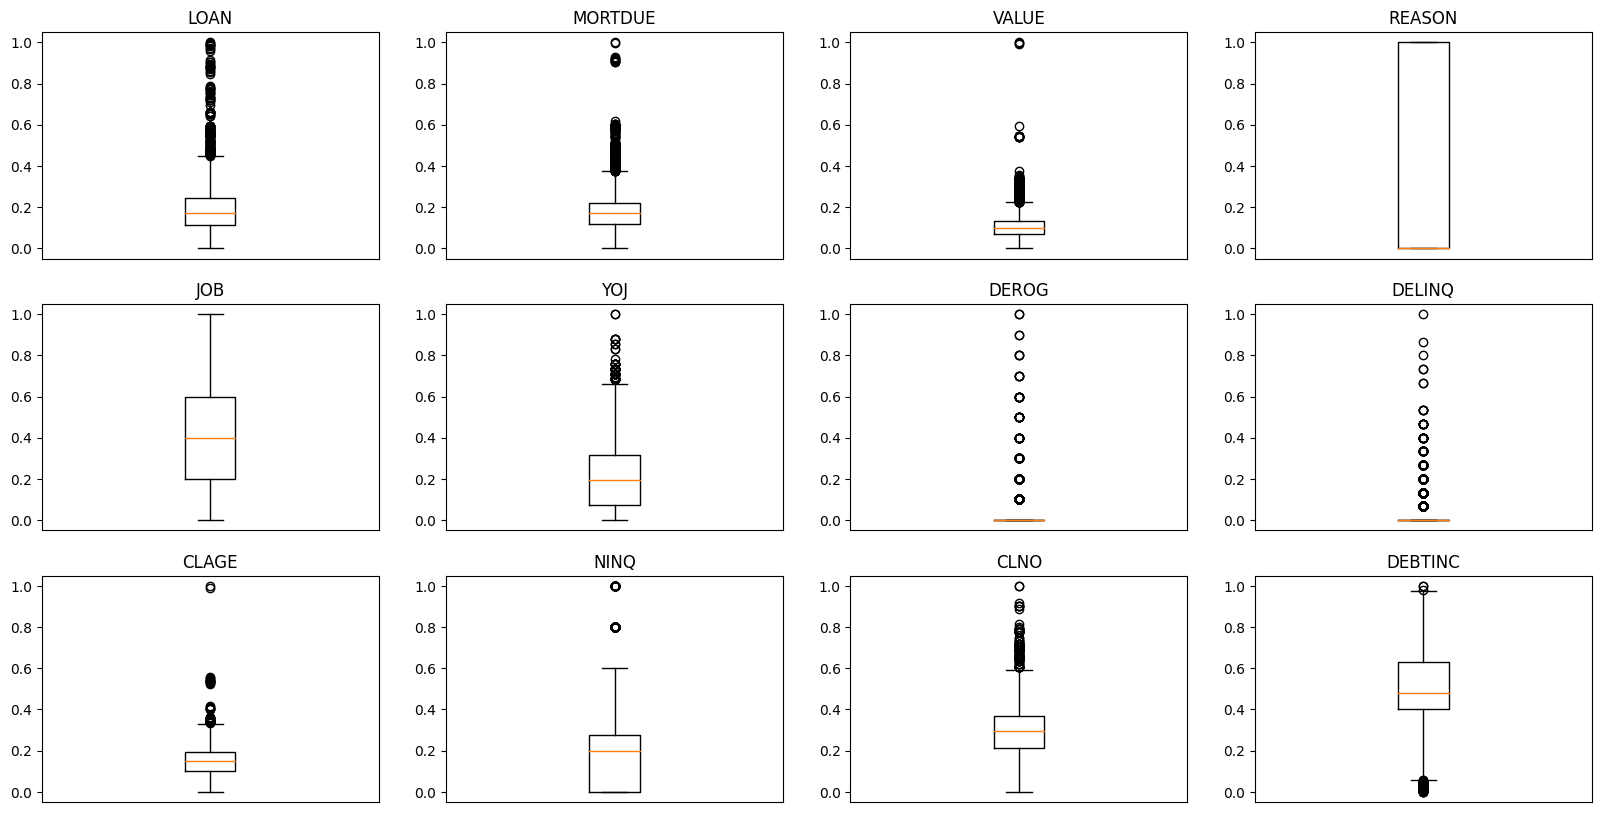

In [156]:
show_outlier(x_train_6)

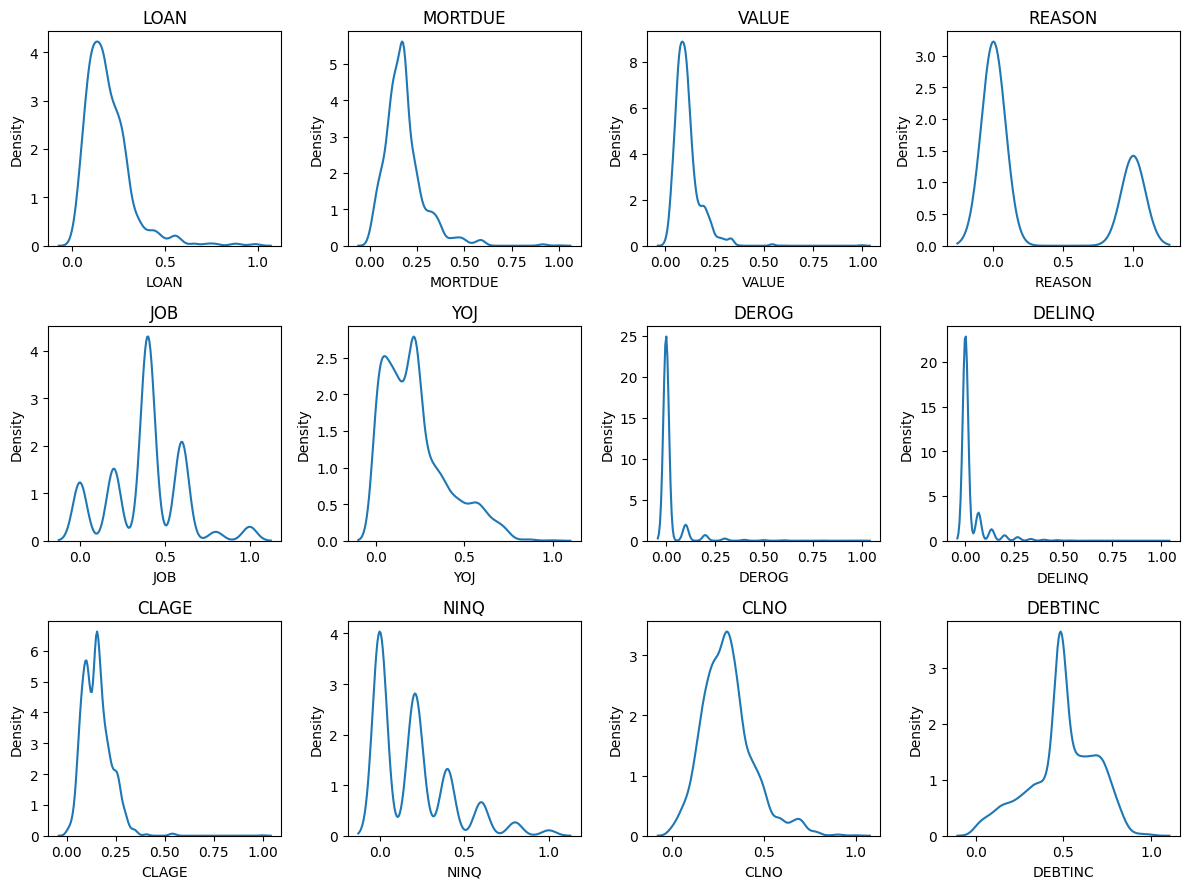

In [157]:
distribution_data(x_train_6)

<p style="color: yellow;">Tạo DF7: Thay thế các giá trị Nan như sau:
<p style="color: yellow;">+ Tách 2 trường dữ liệu REASON và JOB thành các cột
<p style="color: yellow;">+ Loại bỏ cột DEBTINC do có quá nhiều giá trị missing
<p style="color: yellow;">+ Sau đó loại bỏ các hàng mà có bất kì giá trị missing nào
<p style="color: yellow;">Sau đó LabelEncoder những trường chứa giá trị phân loại
<p style="color: yellow;">Thực hiển chuẩn hóa dữ liệu theo StandardScaler or MinMaxScaler

In [41]:
x_train_7, x_test_7, y_train_7, y_test_7 = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

In [43]:
def transform(x, y):
    df = pd.concat([x,y], axis=1)
    df=pd.get_dummies(df, columns=['REASON','JOB'])
    df.drop('DEBTINC', axis=1, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    y_trans = df['BAD']
    x_trans = df.drop(['BAD'], axis=1)
    return x_trans, y_trans

In [44]:
x_train_7, y_train_7 = transform(x_train_7, y_train_7)
x_test_7, y_test_7 = transform(x_test_7, y_test_7)
# LableEncoder 
adjust_inconsistent(x_train_7, 7, True)
adjust_inconsistent(x_test_7, 7, False)
# Chuẩn hóa dữ liệu theo pp StandardScaler
x_train_7, y_train_7 = preprocess_standard(x_train_7, y_train_7, 7)
x_test_7, y_test_7 = preprocess_standard_test(x_test_7, y_test_7, 7)

In [161]:
x_test_7.head()

LOAN   MORTDUE     VALUE       YOJ     DEROG    DELINQ     CLAGE  \
4798  0.589443 -0.730007 -0.616033  1.304566 -0.289686 -0.377537  0.078020   
3716  0.102879 -0.910483 -0.790941  0.649340 -0.289686 -0.377537 -0.688884   
1472 -0.657930 -0.430479 -0.719734 -0.530066 -0.289686 -0.377537  1.746240   
1050 -0.781783 -0.641769 -0.821912 -0.923201 -0.289686  0.555232 -1.124060   
87   -1.277193 -0.354985 -0.651205 -0.726634 -0.289686  0.555232 -0.100859   

          NINQ      CLNO  REASON_DebtCon  REASON_HomeImp   JOB_Mgr  \
4798 -0.097514  0.002834        0.680138       -0.650955 -0.389477   
3716 -0.097514 -0.514004        0.680138       -0.650955 -0.389477   
1472 -0.703849 -1.237578        0.680138       -0.650955 -0.389477   
1050 -0.703849 -0.307269        0.680138       -0.650955 -0.389477   
87   -0.703849 -0.410637       -1.470290        1.536204 -0.389477   

      JOB_Office  JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self  
4798    2.277129  -0.794460    -0.576262  -0.132453 -0.178291  
3716   -0.439150   1.258717    -0.576262  -0.132453 -0.178291  
1472   -0.439150   1.258717    -0.576262  -0.132453 -0.178291  
1050   -0.439150   1.258717    -0.576262  -0.132453 -0.178291  
87     -0.439150   1.258717    -0.576262  -0.132453 -0.178291

<h3>Tuning model - Hyperparameter

In [163]:
# defining plot_roc function function

def plot_roc(model, x_test, y_test):
    
    y_score = model.predict_proba(x_test)[:,1]

    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    plt.figure(figsize=(5,3))
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC plot for prediction")
    plt.legend(loc="lower right")
    plt.show()

In [165]:
def plot_confusion_matrix(y, y_pred):
    plt.figure(figsize=(5.3,3.5))
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='YlOrRd')
    plt.show()

In [166]:
def model_analysis(model, x_test, y_test, y_pred):
    plot_roc(model, x_test, y_test)
    plot_confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))

In [167]:
def tuning_hyperparameter(model, param_grid, x_train, y_train):

    clf = GridSearchCV(model, param_grid, n_jobs=-1, verbose=True, cv=5, scoring='roc_auc')
    grid_result = clf.fit(x_train, y_train)

    # summarize results
    print("Best train: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    return grid_result.best_estimator_

In [168]:
def build_and_analysis(models, param_grids, x_train, y_train, x_test, y_test, index):
    
  for i in range(len(models)):
    model = tuning_hyperparameter(models[i], param_grids[i], x_train, y_train)
    name_model = str(type(model)).split(".")[-1][:-2]
    print(name_model)
    print("Accuracy on Training Dataset : ",model.score(x_train,y_train))
    print("Accuracy on Test Dataset : ",model.score(x_test,y_test))
    model_analysis(model, x_test, y_test, model.predict(x_test))
    pickle.dump(model, open(f"./model_df{index}/{name_model}.pickle", 'wb'))
    print("\n \n \n \n")

<p style="color: yellow;"><strong>Tuning and Build model with dataset DF1

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Best train: 0.781399 using {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
LogisticRegression
Accuracy on Training Dataset :  0.8392659739111209
Accuracy on Test Dataset :  0.8457446808510638


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


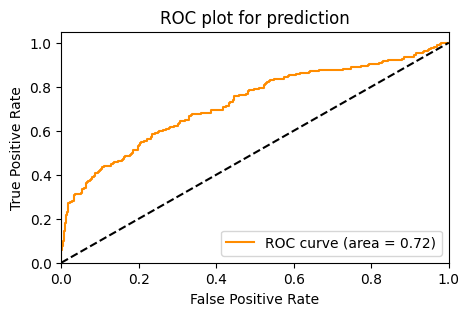

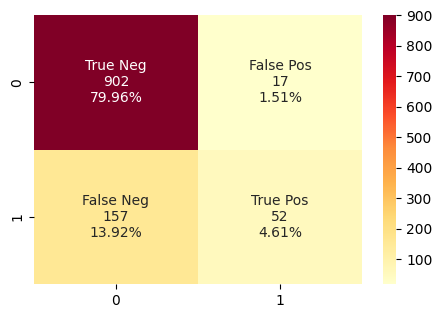

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       919
           1       0.75      0.25      0.37       209

    accuracy                           0.85      1128
   macro avg       0.80      0.62      0.64      1128
weighted avg       0.83      0.85      0.81      1128


 
 
 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best train: 0.795873 using {'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 10}
DecisionTreeClassifier
Accuracy on Training Dataset :  0.9502542560247623
Accuracy on Test Dataset :  0.8572695035460993


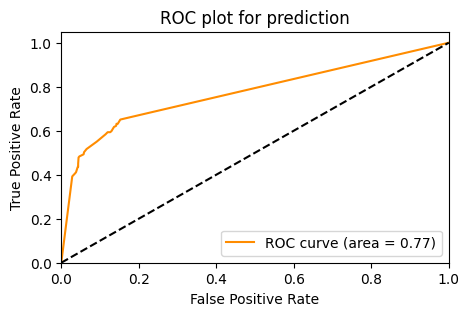

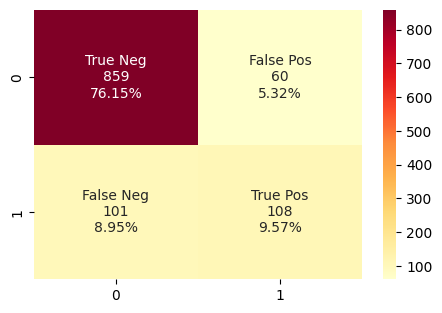

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       919
           1       0.64      0.52      0.57       209

    accuracy                           0.86      1128
   macro avg       0.77      0.73      0.74      1128
weighted avg       0.85      0.86      0.85      1128


 
 
 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best train: 0.823933 using {'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 250}
RandomForestClassifier
Accuracy on Training Dataset :  0.8421401724519124
Accuracy on Test Dataset :  0.8377659574468085


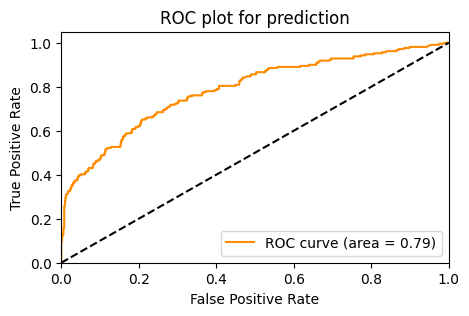

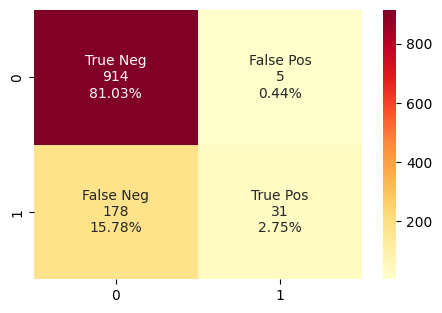

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       919
           1       0.86      0.15      0.25       209

    accuracy                           0.84      1128
   macro avg       0.85      0.57      0.58      1128
weighted avg       0.84      0.84      0.79      1128


 
 
 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.956248 using {'C': 1, 'gamma': 1, 'kernel': 'rbf', 'probability': True}
SVC
Accuracy on Training Dataset :  0.9931461419411894
Accuracy on Test Dataset :  0.8554964539007093


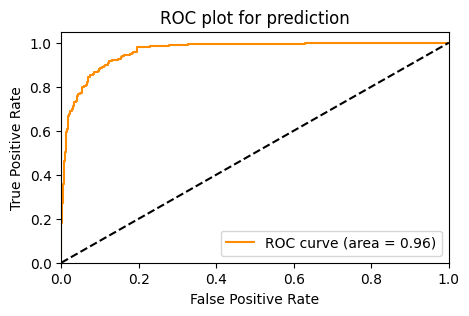

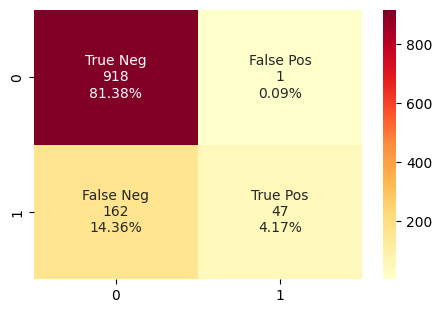

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       919
           1       0.98      0.22      0.37       209

    accuracy                           0.86      1128
   macro avg       0.91      0.61      0.64      1128
weighted avg       0.87      0.86      0.82      1128


 
 
 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best train: 0.973298 using {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 1000}
ExtraTreesClassifier
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.9024822695035462


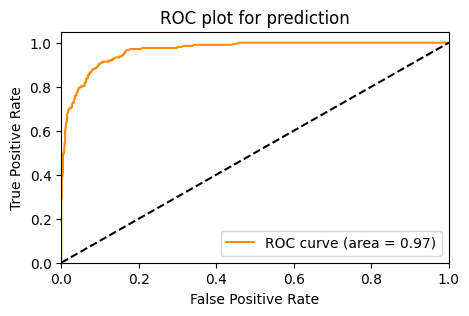

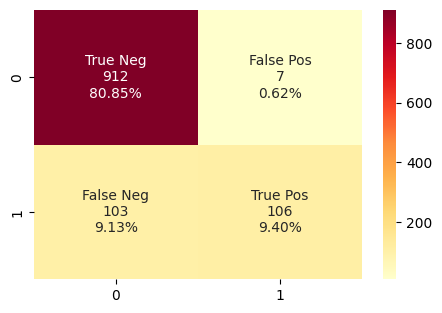

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       919
           1       0.94      0.51      0.66       209

    accuracy                           0.90      1128
   macro avg       0.92      0.75      0.80      1128
weighted avg       0.91      0.90      0.89      1128


 
 
 

Fitting 5 folds for each of 90 candidates, totalling 450 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.950734 using {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 500}
GradientBoostingClassifier
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.9095744680851063


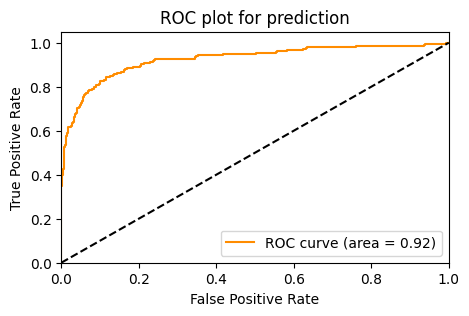

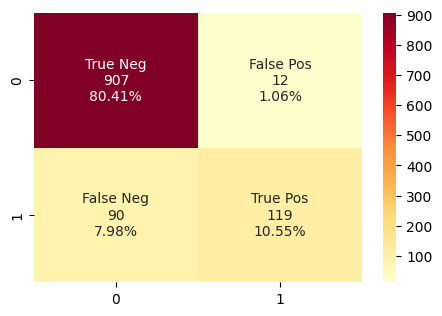

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       919
           1       0.91      0.57      0.70       209

    accuracy                           0.91      1128
   macro avg       0.91      0.78      0.82      1128
weighted avg       0.91      0.91      0.90      1128


 
 
 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best train: 0.851588 using {'learning_rate': 0.2, 'n_estimators': 1000}
AdaBoostClassifier
Accuracy on Training Dataset :  0.8790625690913111
Accuracy on Test Dataset :  0.8670212765957447


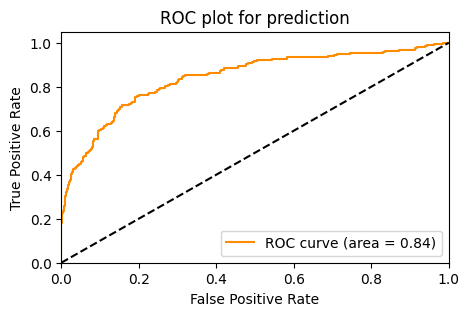

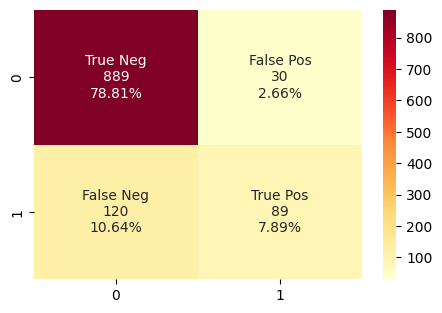

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       919
           1       0.75      0.43      0.54       209

    accuracy                           0.87      1128
   macro avg       0.81      0.70      0.73      1128
weighted avg       0.86      0.87      0.85      1128


 
 
 



In [169]:
build_and_analysis(
    models=[LogisticRegression(), DecisionTreeClassifier(), 
            RandomForestClassifier(), SVC(),
            ExtraTreesClassifier(),     (),
            AdaBoostClassifier()],

    param_grids=[
                    [
                        {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], 'max_iter': [100, 1000, 2500, 5000]},
                        {'penalty': ['l1'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 1000, 2500, 5000]},
                        {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['saga'], 'max_iter': [100, 1000, 2500, 5000], 'l1_ratio': [0.25, 0.5, 0.75]}
                    ],
                    {
                        'max_depth': [5, 10, 15, 20, 25, 30],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4]
                    },
                    {
                        'n_estimators': [25, 50, 100, 150, 200, 250, 300, 400], 
                        'max_features': ['sqrt', 'log2', None], 
                        'max_depth': [3, 6, 9], 
                        'max_leaf_nodes': [3, 6, 9], 
                    }, 
                    {
                        'C': [0.1, 1, 10, 100],  
                        'gamma': [1, 0.1, 0.01],
                        'kernel': ['rbf', 'linear'],
                        'probability': [True]
                    }, 
                    {
                        'n_estimators': [200, 250, 300, 400, 500, 1000], 
                        'criterion': ['gini', 'entropy'],
                        'bootstrap': [True, False],
                        'max_features': ['sqrt', 'log2', None], 
                        # 'max_depth': [i for i in range(2, 15)], 
                        # 'min_samples_split': [2, 5, 8, 10, 15, 20],
                        # 'min_samples_leaf': [2, 5, 8, 10, 15, 20],
                        # 'max_leaf_nodes': [5, 8, 10, 15, 20, 25, 30]
                    },
                    {
                        'n_estimators': [100, 200, 250, 400, 500, 1000],
                        'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                        'max_depth': [3, 5, 10],
                    },
                    {
                        'n_estimators': [100, 200, 250, 400, 500, 1000],
                        'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                    }
                    
    ],

    x_train=x_train_1,
    y_train=y_train_1,
    x_test=x_test_1,
    y_test=y_test_1,
    index=1
)

<p style="color: yellow;"><strong>Tuning and Build model with dataset DF2

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.836935 using {'C': 0.1, 'l1_ratio': 0.75, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
LogisticRegression
Accuracy on Training Dataset :  0.8543733092876465
Accuracy on Test Dataset :  0.8527827648114902


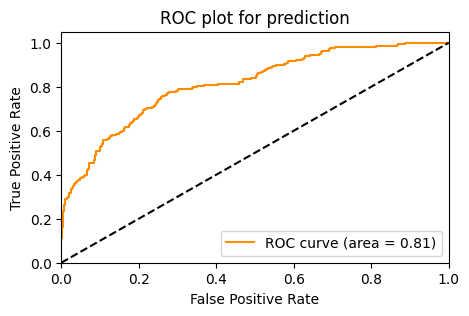

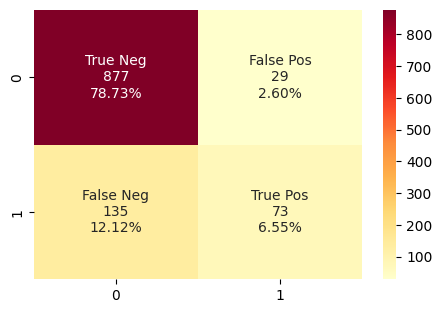

              precision    recall  f1-score   support

           0       0.87      0.97      0.91       906
           1       0.72      0.35      0.47       208

    accuracy                           0.85      1114
   macro avg       0.79      0.66      0.69      1114
weighted avg       0.84      0.85      0.83      1114


 
 
 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best train: 0.919544 using {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}
DecisionTreeClassifier
Accuracy on Training Dataset :  0.9824165915238954
Accuracy on Test Dataset :  0.8734290843806104


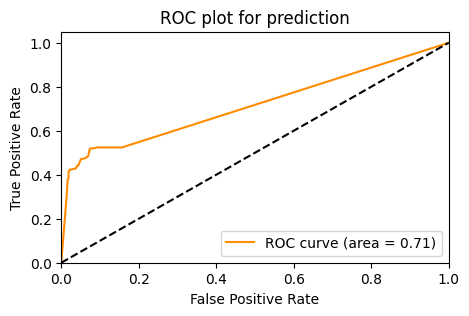

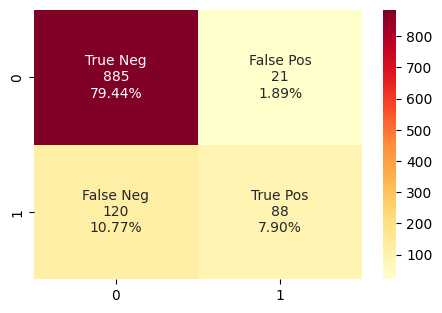

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       906
           1       0.81      0.42      0.56       208

    accuracy                           0.87      1114
   macro avg       0.84      0.70      0.74      1114
weighted avg       0.87      0.87      0.86      1114


 
 
 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best train: 0.937381 using {'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 300}
RandomForestClassifier
Accuracy on Training Dataset :  0.9298917944093779
Accuracy on Test Dataset :  0.8429084380610413


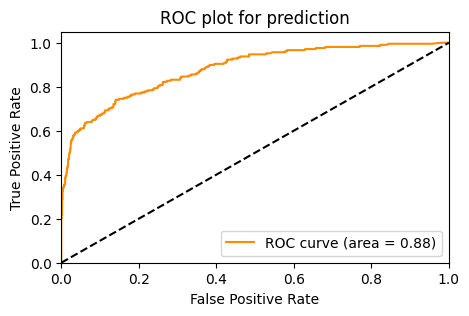

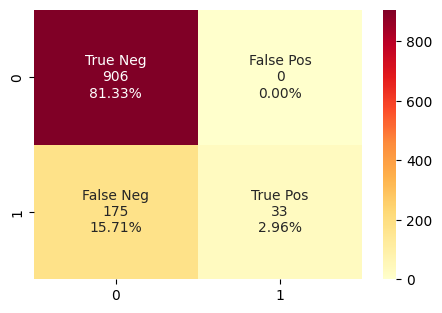

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       906
           1       1.00      0.16      0.27       208

    accuracy                           0.84      1114
   macro avg       0.92      0.58      0.59      1114
weighted avg       0.87      0.84      0.79      1114


 
 
 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.983806 using {'C': 10, 'gamma': 1, 'kernel': 'rbf', 'probability': True}
SVC
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.9120287253141831


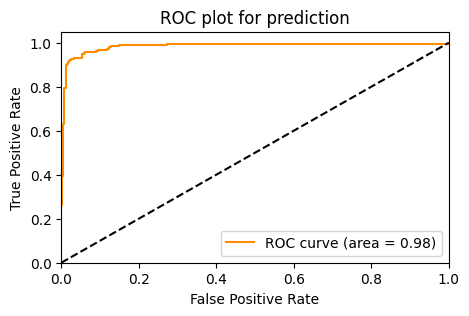

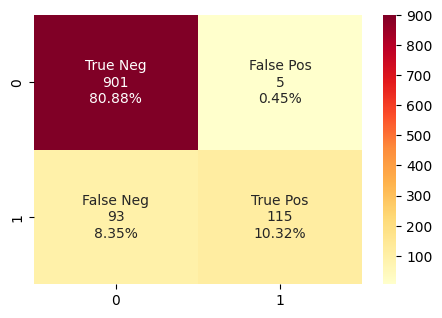

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       906
           1       0.96      0.55      0.70       208

    accuracy                           0.91      1114
   macro avg       0.93      0.77      0.82      1114
weighted avg       0.92      0.91      0.90      1114


 
 
 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best train: 0.992142 using {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 300}
ExtraTreesClassifier
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.9210053859964094


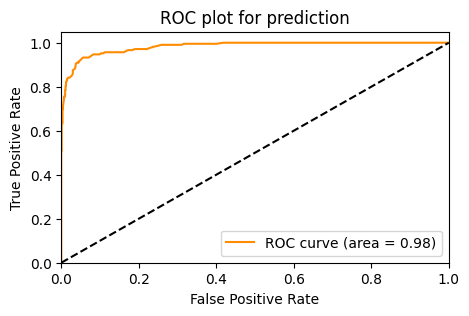

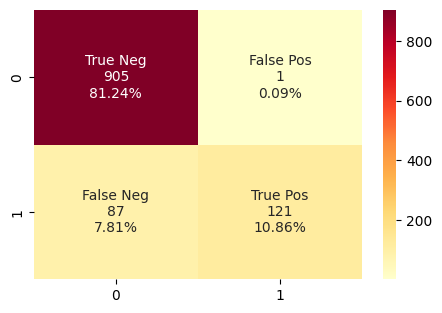

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       906
           1       0.99      0.58      0.73       208

    accuracy                           0.92      1114
   macro avg       0.95      0.79      0.84      1114
weighted avg       0.93      0.92      0.91      1114


 
 
 

Fitting 5 folds for each of 90 candidates, totalling 450 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.976481 using {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
GradientBoostingClassifier
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.8635547576301615


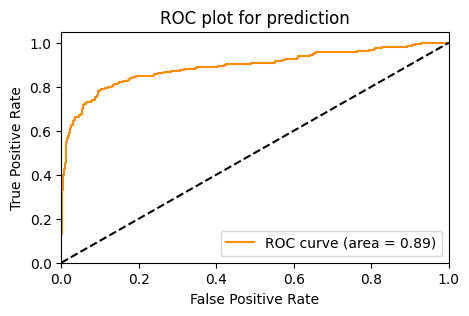

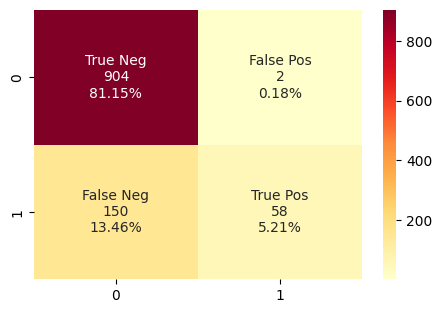

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       906
           1       0.97      0.28      0.43       208

    accuracy                           0.86      1114
   macro avg       0.91      0.64      0.68      1114
weighted avg       0.88      0.86      0.83      1114


 
 
 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best train: 0.952447 using {'learning_rate': 0.2, 'n_estimators': 1000}
AdaBoostClassifier
Accuracy on Training Dataset :  0.9582957619477006
Accuracy on Test Dataset :  0.855475763016158


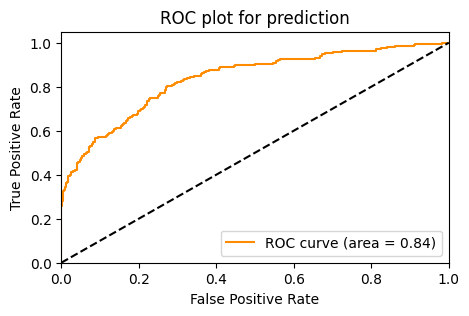

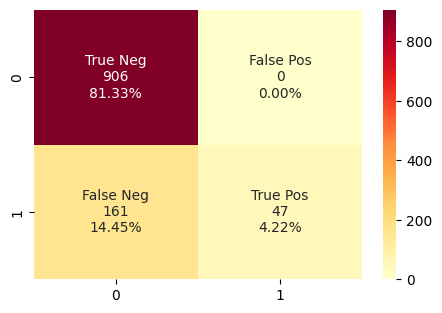

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       906
           1       1.00      0.23      0.37       208

    accuracy                           0.86      1114
   macro avg       0.92      0.61      0.64      1114
weighted avg       0.88      0.86      0.82      1114


 
 
 



In [170]:
build_and_analysis(
    models=[LogisticRegression(), DecisionTreeClassifier(), 
            RandomForestClassifier(), SVC(),
            ExtraTreesClassifier(), GradientBoostingClassifier(),
            AdaBoostClassifier()],

    param_grids=[
                    [
                        {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], 'max_iter': [100, 1000, 2500, 5000]},
                        {'penalty': ['l1'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 1000, 2500, 5000]},
                        {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['saga'], 'max_iter': [100, 1000, 2500, 5000], 'l1_ratio': [0.25, 0.5, 0.75]}
                    ],
                    {
                        'max_depth': [5, 10, 15, 20, 25, 30],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4]
                    },
                    {
                        'n_estimators': [25, 50, 100, 150, 200, 250, 300, 400], 
                        'max_features': ['sqrt', 'log2', None], 
                        'max_depth': [3, 6, 9], 
                        'max_leaf_nodes': [3, 6, 9], 
                    }, 
                    {
                        'C': [0.1, 1, 10, 100],  
                        'gamma': [1, 0.1, 0.01],
                        'kernel': ['rbf', 'linear'],
                        'probability': [True]
                    }, 
                    {
                        'n_estimators': [200, 250, 300, 400, 500, 1000], 
                        'criterion': ['gini', 'entropy'],
                        'bootstrap': [True, False],
                        'max_features': ['sqrt', 'log2', None], 
                        # 'max_depth': [i for i in range(2, 15)], 
                        # 'min_samples_split': [2, 5, 8, 10, 15, 20],
                        # 'min_samples_leaf': [2, 5, 8, 10, 15, 20],
                        # 'max_leaf_nodes': [5, 8, 10, 15, 20, 25, 30]
                    },
                    {
                        'n_estimators': [100, 200, 250, 400, 500, 1000],
                        'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                        'max_depth': [3, 5, 10],
                    },
                    {
                        'n_estimators': [100, 200, 250, 400, 500, 1000],
                        'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                    }
                    
    ],

    x_train=x_train_2,
    y_train=y_train_2,
    x_test=x_test_2,
    y_test=y_test_2,
    index=2
)

<p style="color: yellow;"><strong>Tuning and Build model with dataset DF3

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


Best train: 0.836370 using {'C': 0.1, 'l1_ratio': 0.5, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
LogisticRegression
Accuracy on Training Dataset :  0.8570784490532011
Accuracy on Test Dataset :  0.8527827648114902


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


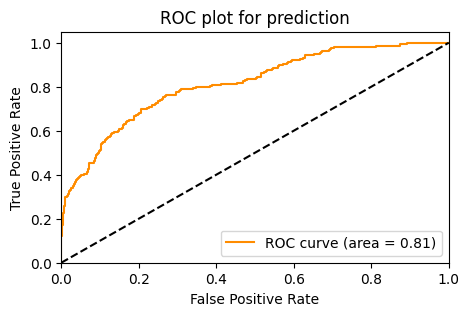

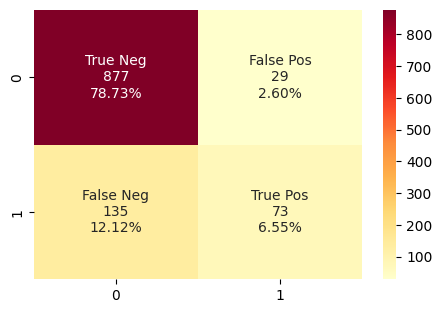

              precision    recall  f1-score   support

           0       0.87      0.97      0.91       906
           1       0.72      0.35      0.47       208

    accuracy                           0.85      1114
   macro avg       0.79      0.66      0.69      1114
weighted avg       0.84      0.85      0.83      1114


 
 
 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best train: 0.921127 using {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}
DecisionTreeClassifier
Accuracy on Training Dataset :  0.981965734896303
Accuracy on Test Dataset :  0.8761220825852782


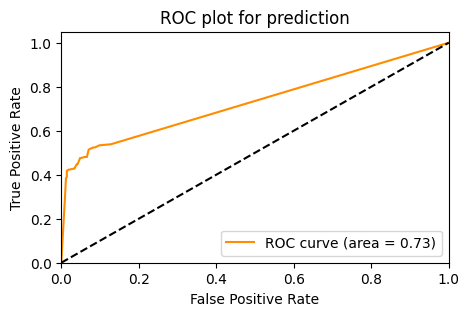

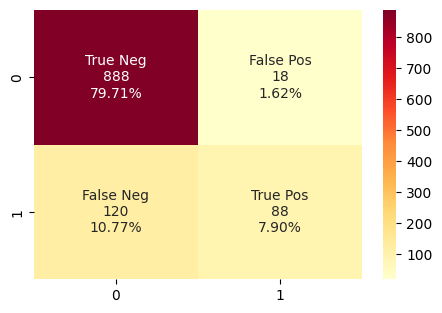

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       906
           1       0.83      0.42      0.56       208

    accuracy                           0.88      1114
   macro avg       0.86      0.70      0.74      1114
weighted avg       0.87      0.88      0.86      1114


 
 
 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best train: 0.936784 using {'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': 9, 'n_estimators': 300}
RandomForestClassifier
Accuracy on Training Dataset :  0.9344003606853021
Accuracy on Test Dataset :  0.8402154398563735


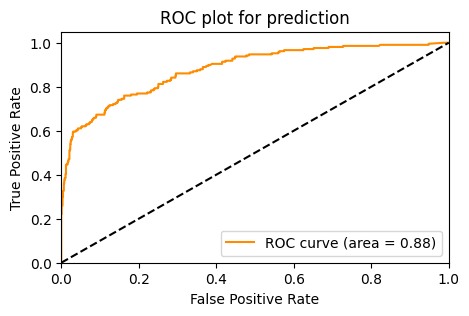

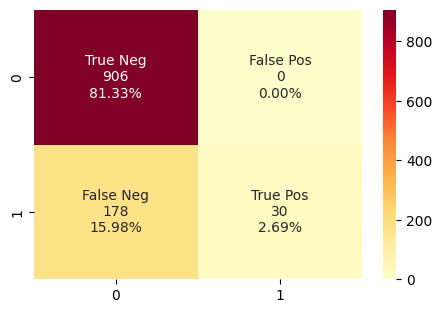

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       906
           1       1.00      0.14      0.25       208

    accuracy                           0.84      1114
   macro avg       0.92      0.57      0.58      1114
weighted avg       0.87      0.84      0.79      1114


 
 
 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.984056 using {'C': 10, 'gamma': 1, 'kernel': 'rbf', 'probability': True}
SVC
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.9048473967684022


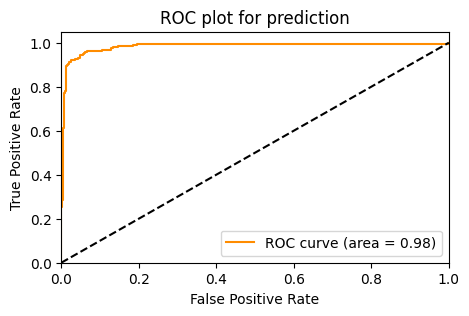

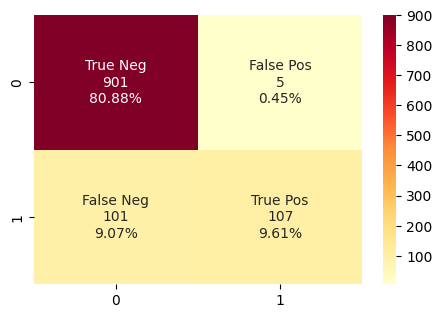

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       906
           1       0.96      0.51      0.67       208

    accuracy                           0.90      1114
   macro avg       0.93      0.75      0.81      1114
weighted avg       0.91      0.90      0.89      1114


 
 
 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best train: 0.992376 using {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 500}
ExtraTreesClassifier
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.9174147217235189


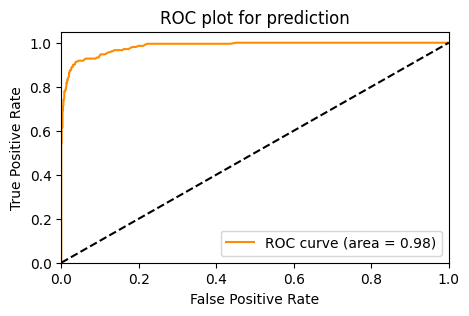

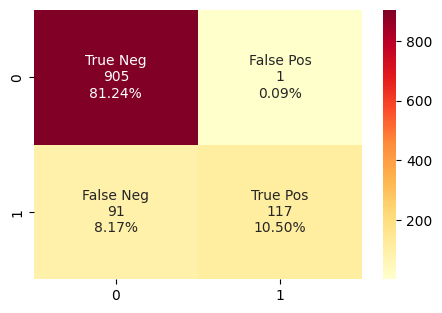

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       906
           1       0.99      0.56      0.72       208

    accuracy                           0.92      1114
   macro avg       0.95      0.78      0.83      1114
weighted avg       0.92      0.92      0.91      1114


 
 
 

Fitting 5 folds for each of 90 candidates, totalling 450 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.975591 using {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 1000}
GradientBoostingClassifier
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.8716337522441652


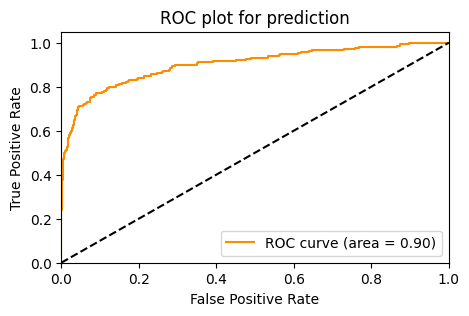

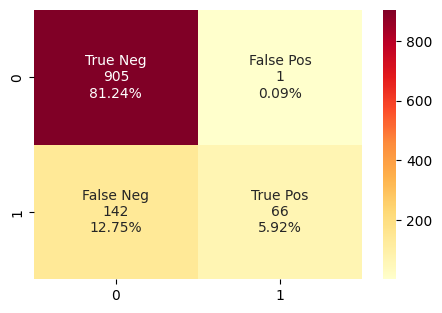

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       906
           1       0.99      0.32      0.48       208

    accuracy                           0.87      1114
   macro avg       0.92      0.66      0.70      1114
weighted avg       0.89      0.87      0.84      1114


 
 
 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best train: 0.952213 using {'learning_rate': 0.2, 'n_estimators': 1000}
AdaBoostClassifier
Accuracy on Training Dataset :  0.9582957619477006
Accuracy on Test Dataset :  0.855475763016158


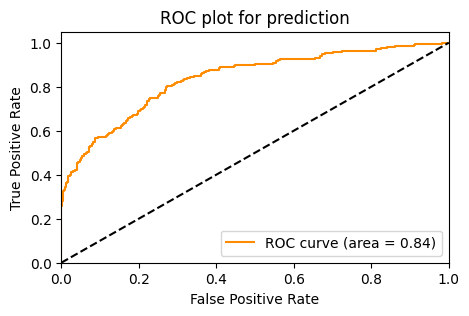

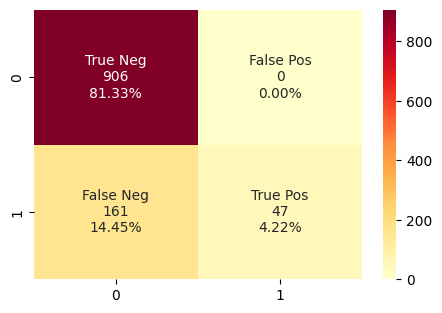

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       906
           1       1.00      0.23      0.37       208

    accuracy                           0.86      1114
   macro avg       0.92      0.61      0.64      1114
weighted avg       0.88      0.86      0.82      1114


 
 
 



In [171]:
build_and_analysis(
    models=[LogisticRegression(), DecisionTreeClassifier(), 
            RandomForestClassifier(), SVC(),
            ExtraTreesClassifier(), GradientBoostingClassifier(),
            AdaBoostClassifier()],

    param_grids=[
                    [
                        {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], 'max_iter': [100, 1000, 2500, 5000]},
                        {'penalty': ['l1'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 1000, 2500, 5000]},
                        {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['saga'], 'max_iter': [100, 1000, 2500, 5000], 'l1_ratio': [0.25, 0.5, 0.75]}
                    ],
                    {
                        'max_depth': [5, 10, 15, 20, 25, 30],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4]
                    },
                    {
                        'n_estimators': [25, 50, 100, 150, 200, 250, 300, 400], 
                        'max_features': ['sqrt', 'log2', None], 
                        'max_depth': [3, 6, 9], 
                        'max_leaf_nodes': [3, 6, 9], 
                    }, 
                    {
                        'C': [0.1, 1, 10, 100],  
                        'gamma': [1, 0.1, 0.01],
                        'kernel': ['rbf', 'linear'],
                        'probability': [True]
                    }, 
                    {
                        'n_estimators': [200, 250, 300, 400, 500, 1000], 
                        'criterion': ['gini', 'entropy'],
                        'bootstrap': [True, False],
                        'max_features': ['sqrt', 'log2', None], 
                        # 'max_depth': [i for i in range(2, 15)], 
                        # 'min_samples_split': [2, 5, 8, 10, 15, 20],
                        # 'min_samples_leaf': [2, 5, 8, 10, 15, 20],
                        # 'max_leaf_nodes': [5, 8, 10, 15, 20, 25, 30]
                    },
                    {
                        'n_estimators': [100, 200, 250, 400, 500, 1000],
                        'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                        'max_depth': [3, 5, 10],
                    },
                    {
                        'n_estimators': [100, 200, 250, 400, 500, 1000],
                        'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                    }
                    
    ],

    x_train=x_train_3,
    y_train=y_train_3,
    x_test=x_test_3,
    y_test=y_test_3,
    index=3
)

<p style="color: yellow;"><strong>Tuning and Build model with dataset DF4

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


Best train: 0.786046 using {'C': 0.01, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'saga'}
LogisticRegression
Accuracy on Training Dataset :  0.8412375790424571
Accuracy on Test Dataset :  0.849005424954792


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


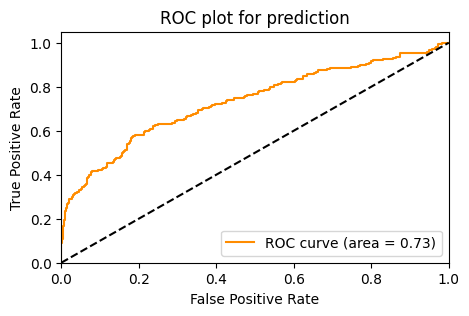

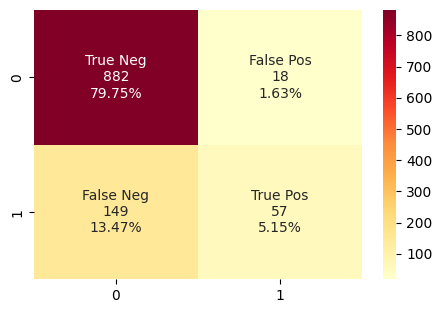

              precision    recall  f1-score   support

           0       0.86      0.98      0.91       900
           1       0.76      0.28      0.41       206

    accuracy                           0.85      1106
   macro avg       0.81      0.63      0.66      1106
weighted avg       0.84      0.85      0.82      1106


 
 
 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best train: 0.861291 using {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
DecisionTreeClassifier
Accuracy on Training Dataset :  0.9302168021680217
Accuracy on Test Dataset :  0.8634719710669078


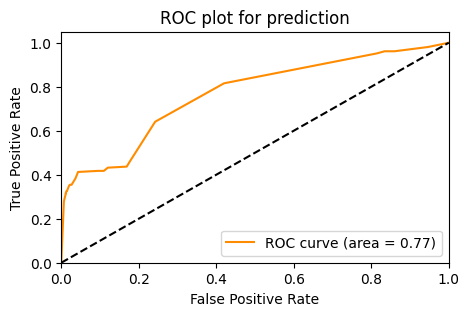

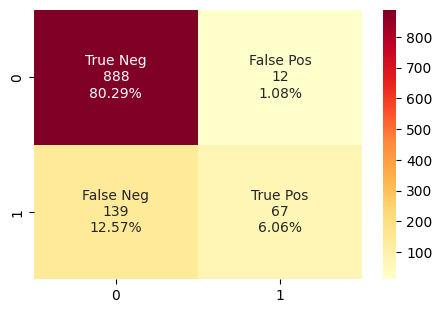

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       900
           1       0.85      0.33      0.47       206

    accuracy                           0.86      1106
   macro avg       0.86      0.66      0.70      1106
weighted avg       0.86      0.86      0.84      1106


 
 
 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best train: 0.899134 using {'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': 9, 'n_estimators': 250}
RandomForestClassifier
Accuracy on Training Dataset :  0.8649503161698283
Accuracy on Test Dataset :  0.8245931283905967


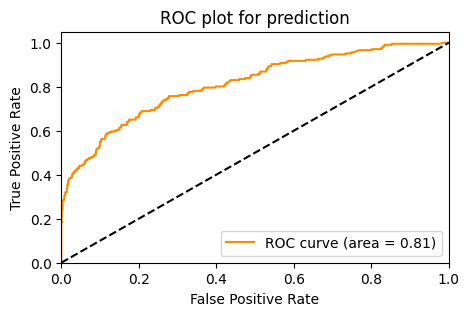

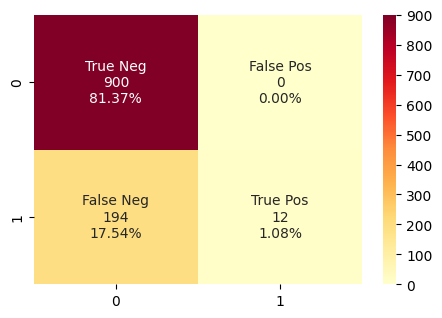

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       900
           1       1.00      0.06      0.11       206

    accuracy                           0.82      1106
   macro avg       0.91      0.53      0.51      1106
weighted avg       0.86      0.82      0.76      1106


 
 
 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.973641 using {'C': 1, 'gamma': 1, 'kernel': 'rbf', 'probability': True}
SVC
Accuracy on Training Dataset :  0.9925474254742548
Accuracy on Test Dataset :  0.8842676311030742


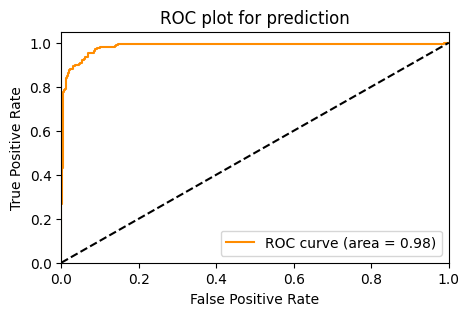

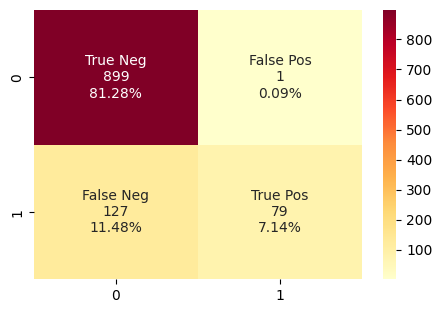

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       900
           1       0.99      0.38      0.55       206

    accuracy                           0.88      1106
   macro avg       0.93      0.69      0.74      1106
weighted avg       0.90      0.88      0.86      1106


 
 
 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best train: 0.979751 using {'bootstrap': False, 'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1000}
ExtraTreesClassifier
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.9249547920433996


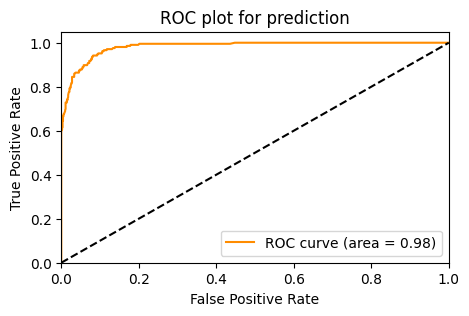

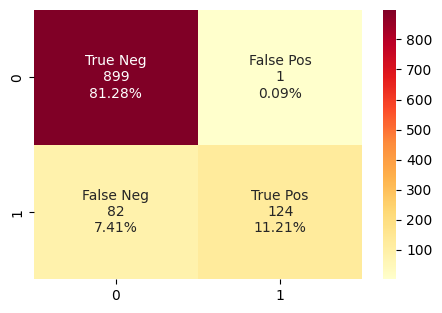

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       900
           1       0.99      0.60      0.75       206

    accuracy                           0.92      1106
   macro avg       0.95      0.80      0.85      1106
weighted avg       0.93      0.92      0.92      1106


 
 
 

Fitting 5 folds for each of 90 candidates, totalling 450 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.963631 using {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 1000}
GradientBoostingClassifier
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.8978300180831826


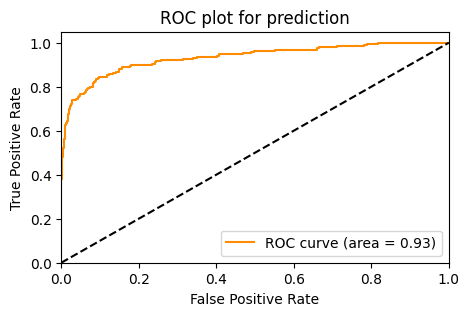

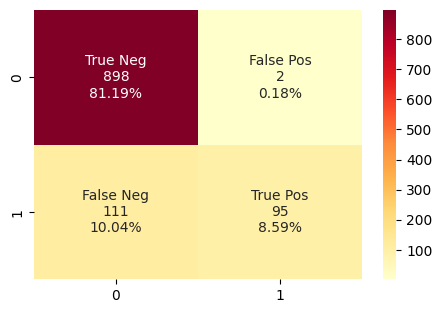

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       900
           1       0.98      0.46      0.63       206

    accuracy                           0.90      1106
   macro avg       0.93      0.73      0.78      1106
weighted avg       0.91      0.90      0.88      1106


 
 
 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best train: 0.917054 using {'learning_rate': 0.1, 'n_estimators': 1000}
AdaBoostClassifier
Accuracy on Training Dataset :  0.9103432700993677
Accuracy on Test Dataset :  0.8535262206148282


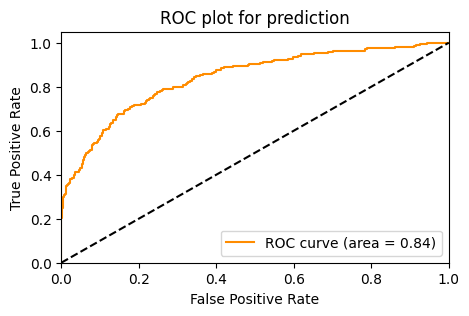

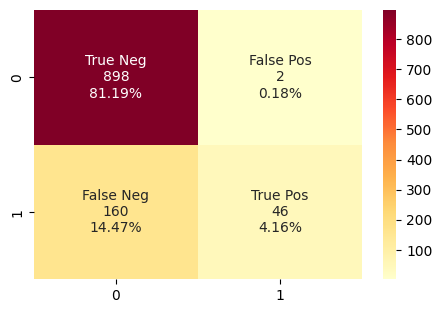

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       900
           1       0.96      0.22      0.36       206

    accuracy                           0.85      1106
   macro avg       0.90      0.61      0.64      1106
weighted avg       0.87      0.85      0.81      1106


 
 
 



In [172]:
build_and_analysis(
    models=[LogisticRegression(), DecisionTreeClassifier(), 
            RandomForestClassifier(), SVC(),
            ExtraTreesClassifier(), GradientBoostingClassifier(),
            AdaBoostClassifier()],

    param_grids=[
                    [
                        {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], 'max_iter': [100, 1000, 2500, 5000]},
                        {'penalty': ['l1'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 1000, 2500, 5000]},
                        {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['saga'], 'max_iter': [100, 1000, 2500, 5000], 'l1_ratio': [0.25, 0.5, 0.75]}
                    ],
                    {
                        'max_depth': [5, 10, 15, 20, 25, 30],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4]
                    },
                    {
                        'n_estimators': [25, 50, 100, 150, 200, 250, 300, 400], 
                        'max_features': ['sqrt', 'log2', None], 
                        'max_depth': [3, 6, 9], 
                        'max_leaf_nodes': [3, 6, 9], 
                    }, 
                    {
                        'C': [0.1, 1, 10, 100],  
                        'gamma': [1, 0.1, 0.01],
                        'kernel': ['rbf', 'linear'],
                        'probability': [True]
                    }, 
                    {
                        'n_estimators': [200, 250, 300, 400, 500, 1000], 
                        'criterion': ['gini', 'entropy'],
                        'bootstrap': [True, False],
                        'max_features': ['sqrt', 'log2', None], 
                        # 'max_depth': [i for i in range(2, 15)], 
                        # 'min_samples_split': [2, 5, 8, 10, 15, 20],
                        # 'min_samples_leaf': [2, 5, 8, 10, 15, 20],
                        # 'max_leaf_nodes': [5, 8, 10, 15, 20, 25, 30]
                    },
                    {
                        'n_estimators': [100, 200, 250, 400, 500, 1000],
                        'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                        'max_depth': [3, 5, 10],
                    },
                    {
                        'n_estimators': [100, 200, 250, 400, 500, 1000],
                        'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                    }
                    
    ],

    x_train=x_train_4,
    y_train=y_train_4,
    x_test=x_test_4,
    y_test=y_test_4,
    index=4
)

<p style="color: yellow;"><strong>Tuning and Build model with dataset DF5

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.784450 using {'C': 0.01, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
LogisticRegression
Accuracy on Training Dataset :  0.8405600722673894
Accuracy on Test Dataset :  0.8471971066907775


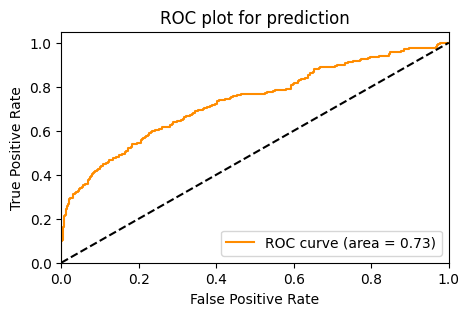

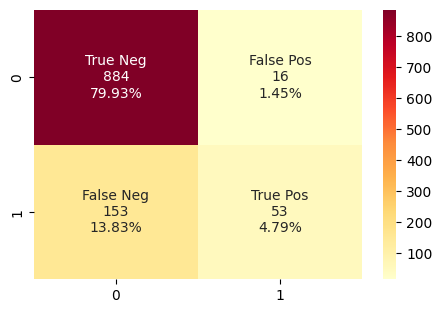

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       900
           1       0.77      0.26      0.39       206

    accuracy                           0.85      1106
   macro avg       0.81      0.62      0.65      1106
weighted avg       0.84      0.85      0.81      1106


 
 
 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best train: 0.863450 using {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
DecisionTreeClassifier
Accuracy on Training Dataset :  0.9275067750677507
Accuracy on Test Dataset :  0.8589511754068716


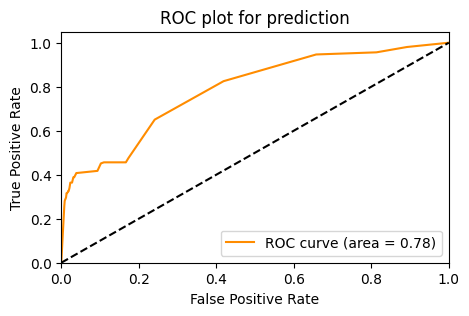

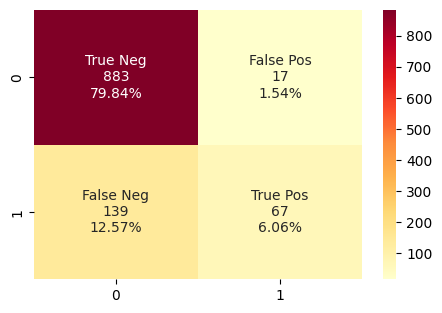

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       900
           1       0.80      0.33      0.46       206

    accuracy                           0.86      1106
   macro avg       0.83      0.65      0.69      1106
weighted avg       0.85      0.86      0.83      1106


 
 
 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best train: 0.898915 using {'max_depth': 6, 'max_features': 'log2', 'max_leaf_nodes': 9, 'n_estimators': 200}
RandomForestClassifier
Accuracy on Training Dataset :  0.8633694670280037
Accuracy on Test Dataset :  0.8327305605786618


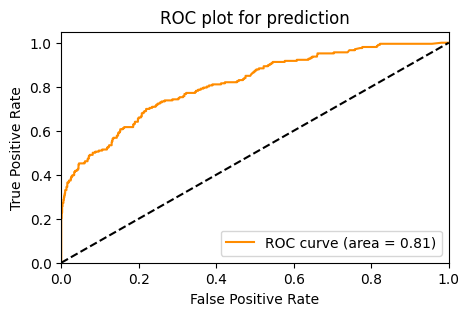

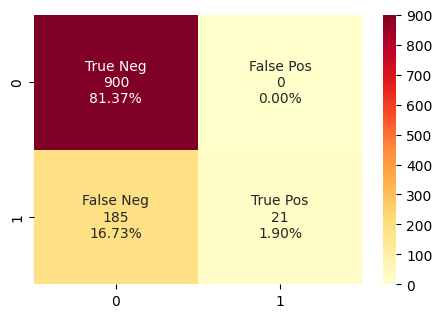

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       900
           1       1.00      0.10      0.19       206

    accuracy                           0.83      1106
   macro avg       0.91      0.55      0.55      1106
weighted avg       0.86      0.83      0.77      1106


 
 
 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.964138 using {'C': 1, 'gamma': 1, 'kernel': 'rbf', 'probability': True}
SVC
Accuracy on Training Dataset :  0.9869015356820234
Accuracy on Test Dataset :  0.8851717902350814


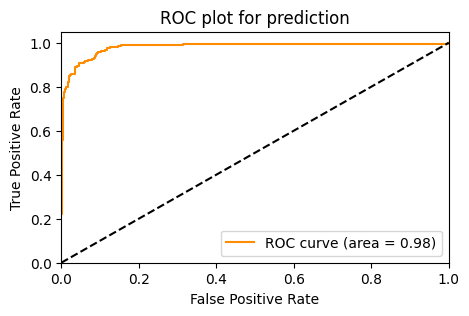

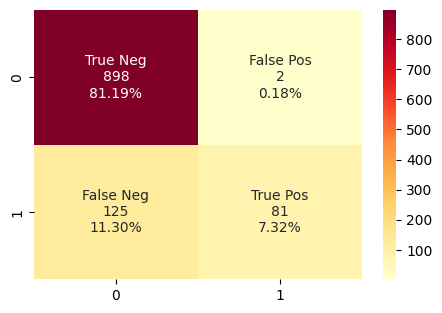

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       900
           1       0.98      0.39      0.56       206

    accuracy                           0.89      1106
   macro avg       0.93      0.70      0.75      1106
weighted avg       0.90      0.89      0.86      1106


 
 
 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best train: 0.975526 using {'bootstrap': False, 'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1000}
ExtraTreesClassifier
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.9213381555153707


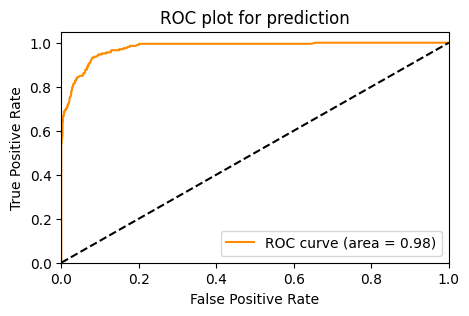

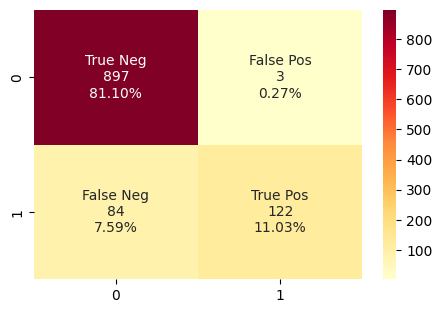

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       900
           1       0.98      0.59      0.74       206

    accuracy                           0.92      1106
   macro avg       0.95      0.79      0.85      1106
weighted avg       0.93      0.92      0.91      1106


 
 
 

Fitting 5 folds for each of 90 candidates, totalling 450 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.962682 using {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 500}
GradientBoostingClassifier
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.8869801084990958


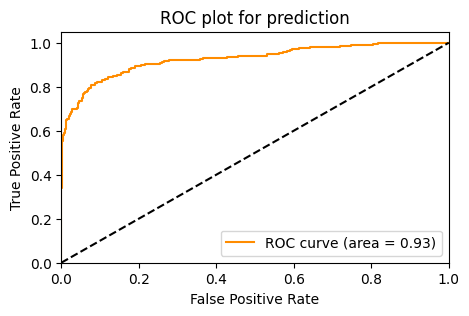

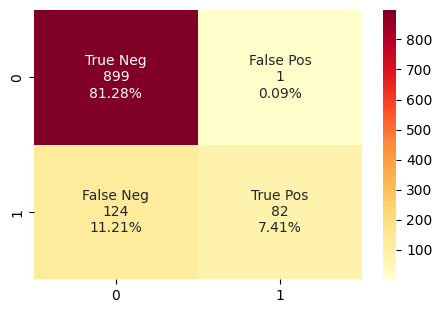

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       900
           1       0.99      0.40      0.57       206

    accuracy                           0.89      1106
   macro avg       0.93      0.70      0.75      1106
weighted avg       0.90      0.89      0.87      1106


 
 
 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best train: 0.912552 using {'learning_rate': 0.2, 'n_estimators': 500}
AdaBoostClassifier
Accuracy on Training Dataset :  0.9107949412827462
Accuracy on Test Dataset :  0.8517179023508138


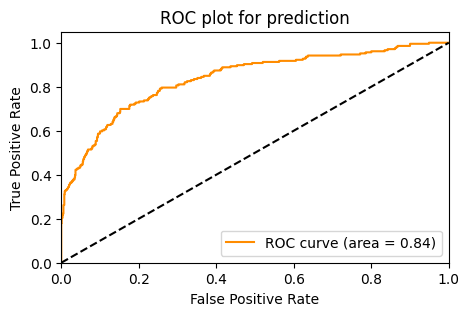

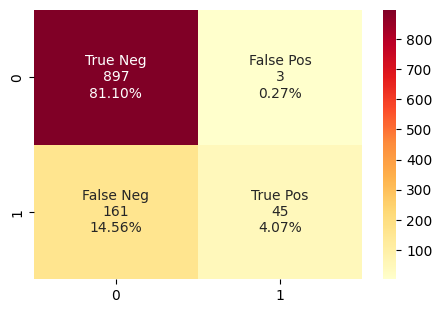

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       900
           1       0.94      0.22      0.35       206

    accuracy                           0.85      1106
   macro avg       0.89      0.61      0.64      1106
weighted avg       0.86      0.85      0.81      1106


 
 
 



In [173]:
build_and_analysis(
    models=[LogisticRegression(), DecisionTreeClassifier(), 
            RandomForestClassifier(), SVC(),
            ExtraTreesClassifier(), GradientBoostingClassifier(),
            AdaBoostClassifier()],

    param_grids=[
                    [
                        {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], 'max_iter': [100, 1000, 2500, 5000]},
                        {'penalty': ['l1'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 1000, 2500, 5000]},
                        {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['saga'], 'max_iter': [100, 1000, 2500, 5000], 'l1_ratio': [0.25, 0.5, 0.75]}
                    ],
                    {
                        'max_depth': [5, 10, 15, 20, 25, 30],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4]
                    },
                    {
                        'n_estimators': [25, 50, 100, 150, 200, 250, 300, 400], 
                        'max_features': ['sqrt', 'log2', None], 
                        'max_depth': [3, 6, 9], 
                        'max_leaf_nodes': [3, 6, 9], 
                    }, 
                    {
                        'C': [0.1, 1, 10, 100],  
                        'gamma': [1, 0.1, 0.01],
                        'kernel': ['rbf', 'linear'],
                        'probability': [True]
                    }, 
                    {
                        'n_estimators': [200, 250, 300, 400, 500, 1000], 
                        'criterion': ['gini', 'entropy'],
                        'bootstrap': [True, False],
                        'max_features': ['sqrt', 'log2', None], 
                        # 'max_depth': [i for i in range(2, 15)], 
                        # 'min_samples_split': [2, 5, 8, 10, 15, 20],
                        # 'min_samples_leaf': [2, 5, 8, 10, 15, 20],
                        # 'max_leaf_nodes': [5, 8, 10, 15, 20, 25, 30]
                    },
                    {
                        'n_estimators': [100, 200, 250, 400, 500, 1000],
                        'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                        'max_depth': [3, 5, 10],
                    },
                    {
                        'n_estimators': [100, 200, 250, 400, 500, 1000],
                        'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                    }
                    
    ],

    x_train=x_train_5,
    y_train=y_train_5,
    x_test=x_test_5,
    y_test=y_test_5,
    index=5
)

<p style="color: yellow;"><strong>Tuning and Build model with dataset DF6

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.785634 using {'C': 1000, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
LogisticRegression
Accuracy on Training Dataset :  0.8398825654923215
Accuracy on Test Dataset :  0.8471971066907775


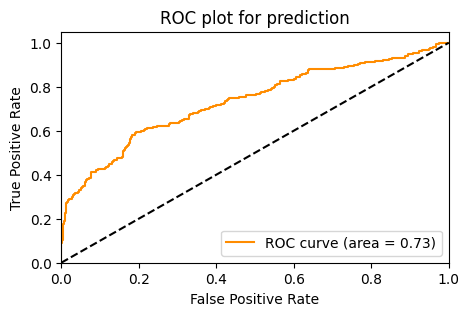

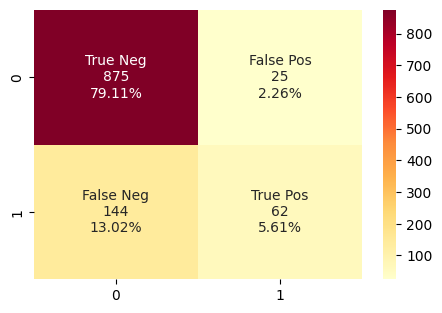

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       900
           1       0.71      0.30      0.42       206

    accuracy                           0.85      1106
   macro avg       0.79      0.64      0.67      1106
weighted avg       0.83      0.85      0.82      1106


 
 
 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best train: 0.857971 using {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
DecisionTreeClassifier
Accuracy on Training Dataset :  0.9290876242095755
Accuracy on Test Dataset :  0.8616636528028933


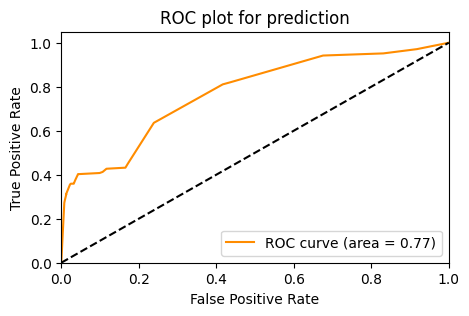

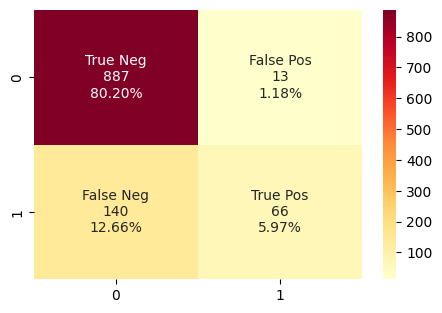

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       900
           1       0.84      0.32      0.46       206

    accuracy                           0.86      1106
   macro avg       0.85      0.65      0.69      1106
weighted avg       0.86      0.86      0.84      1106


 
 
 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best train: 0.898787 using {'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': 9, 'n_estimators': 200}
RandomForestClassifier
Accuracy on Training Dataset :  0.8649503161698283
Accuracy on Test Dataset :  0.8264014466546112


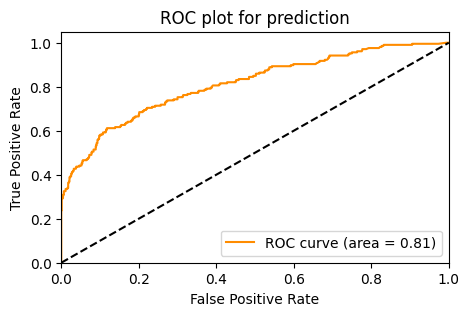

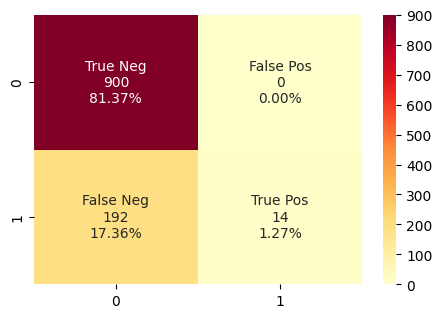

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       900
           1       1.00      0.07      0.13       206

    accuracy                           0.83      1106
   macro avg       0.91      0.53      0.52      1106
weighted avg       0.86      0.83      0.76      1106


 
 
 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.873647 using {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True}
SVC
Accuracy on Training Dataset :  0.9155374887082204
Accuracy on Test Dataset :  0.895117540687161


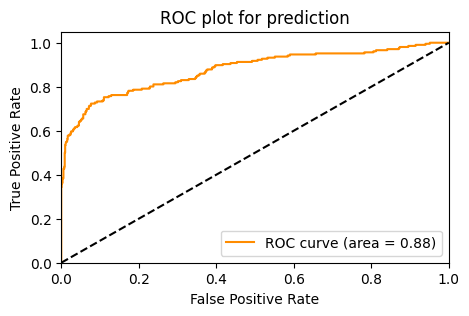

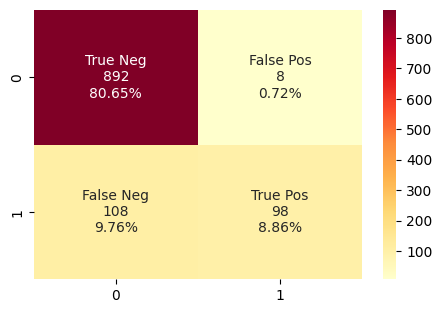

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       900
           1       0.92      0.48      0.63       206

    accuracy                           0.90      1106
   macro avg       0.91      0.73      0.78      1106
weighted avg       0.90      0.90      0.88      1106


 
 
 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best train: 0.979553 using {'bootstrap': False, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 400}
ExtraTreesClassifier
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.9240506329113924


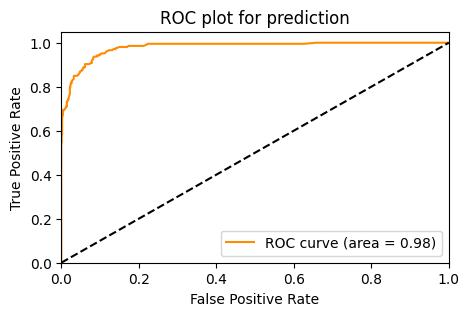

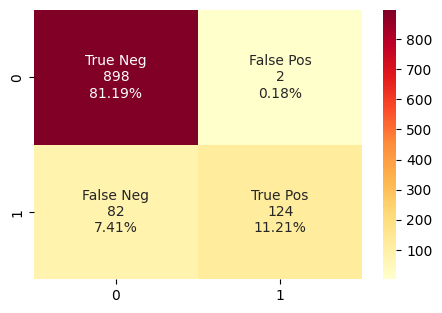

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       900
           1       0.98      0.60      0.75       206

    accuracy                           0.92      1106
   macro avg       0.95      0.80      0.85      1106
weighted avg       0.93      0.92      0.92      1106


 
 
 

Fitting 5 folds for each of 90 candidates, totalling 450 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.964039 using {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 1000}
GradientBoostingClassifier
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.895117540687161


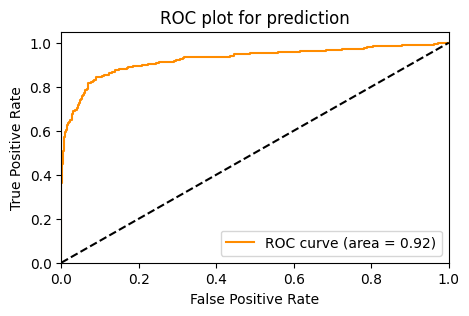

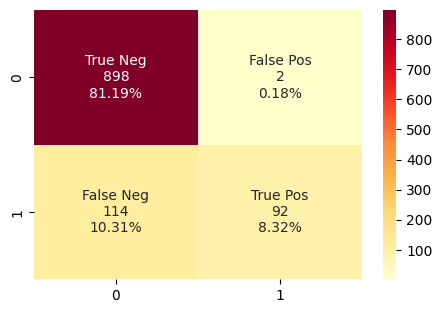

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       900
           1       0.98      0.45      0.61       206

    accuracy                           0.90      1106
   macro avg       0.93      0.72      0.78      1106
weighted avg       0.90      0.90      0.88      1106


 
 
 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best train: 0.917106 using {'learning_rate': 0.1, 'n_estimators': 1000}
AdaBoostClassifier
Accuracy on Training Dataset :  0.9103432700993677
Accuracy on Test Dataset :  0.8535262206148282


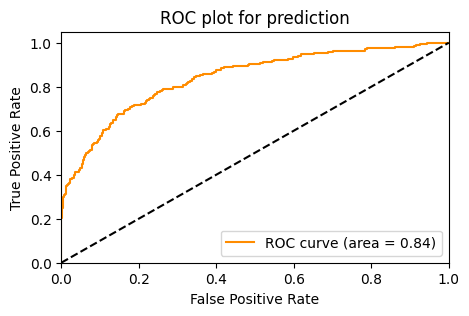

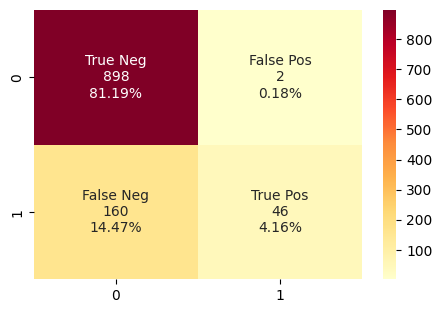

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       900
           1       0.96      0.22      0.36       206

    accuracy                           0.85      1106
   macro avg       0.90      0.61      0.64      1106
weighted avg       0.87      0.85      0.81      1106


 
 
 



In [174]:
build_and_analysis(
    models=[LogisticRegression(), DecisionTreeClassifier(), 
            RandomForestClassifier(), SVC(),
            ExtraTreesClassifier(), GradientBoostingClassifier(),
            AdaBoostClassifier()],

    param_grids=[
                    [
                        {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], 'max_iter': [100, 1000, 2500, 5000]},
                        {'penalty': ['l1'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 1000, 2500, 5000]},
                        {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['saga'], 'max_iter': [100, 1000, 2500, 5000], 'l1_ratio': [0.25, 0.5, 0.75]}
                    ],
                    {
                        'max_depth': [5, 10, 15, 20, 25, 30],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4]
                    },
                    {
                        'n_estimators': [25, 50, 100, 150, 200, 250, 300, 400], 
                        'max_features': ['sqrt', 'log2', None], 
                        'max_depth': [3, 6, 9], 
                        'max_leaf_nodes': [3, 6, 9], 
                    }, 
                    {
                        'C': [0.1, 1, 10, 100],  
                        'gamma': [1, 0.1, 0.01],
                        'kernel': ['rbf', 'linear'],
                        'probability': [True]
                    }, 
                    {
                        'n_estimators': [200, 250, 300, 400, 500, 1000], 
                        'criterion': ['gini', 'entropy'],
                        'bootstrap': [True, False],
                        'max_features': ['sqrt', 'log2', None], 
                        # 'max_depth': [i for i in range(2, 15)], 
                        # 'min_samples_split': [2, 5, 8, 10, 15, 20],
                        # 'min_samples_leaf': [2, 5, 8, 10, 15, 20],
                        # 'max_leaf_nodes': [5, 8, 10, 15, 20, 25, 30]
                    },
                    {
                        'n_estimators': [100, 200, 250, 400, 500, 1000],
                        'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                        'max_depth': [3, 5, 10],
                    },
                    {
                        'n_estimators': [100, 200, 250, 400, 500, 1000],
                        'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                    }
                    
    ],

    x_train=x_train_6,
    y_train=y_train_6,
    x_test=x_test_6,
    y_test=y_test_6,
    index=6
)

<p style="color: yellow;"><strong>Tuning and Build model with dataset DF7

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


Best train: 0.819121 using {'C': 10, 'l1_ratio': 0.5, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
LogisticRegression
Accuracy on Training Dataset :  0.8439796495195026
Accuracy on Test Dataset :  0.8344444444444444


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


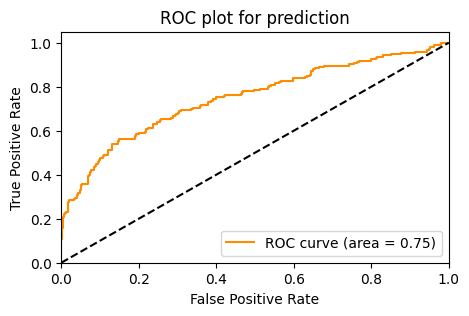

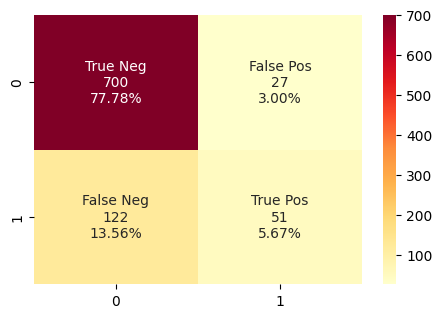

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       727
           1       0.65      0.29      0.41       173

    accuracy                           0.83       900
   macro avg       0.75      0.63      0.66       900
weighted avg       0.81      0.83      0.81       900


 
 
 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best train: 0.829930 using {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10}
DecisionTreeClassifier
Accuracy on Training Dataset :  0.964104013566987
Accuracy on Test Dataset :  0.8788888888888889


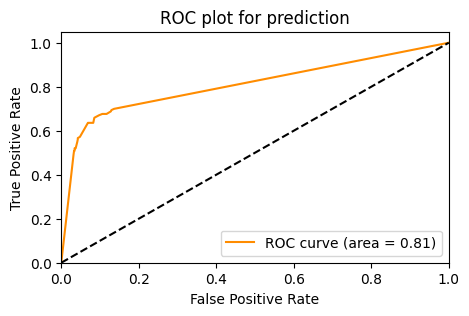

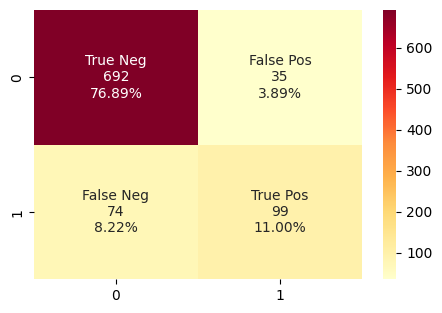

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       727
           1       0.74      0.57      0.64       173

    accuracy                           0.88       900
   macro avg       0.82      0.76      0.79       900
weighted avg       0.87      0.88      0.87       900


 
 
 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best train: 0.845467 using {'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 200}
RandomForestClassifier
Accuracy on Training Dataset :  0.8439796495195026
Accuracy on Test Dataset :  0.84


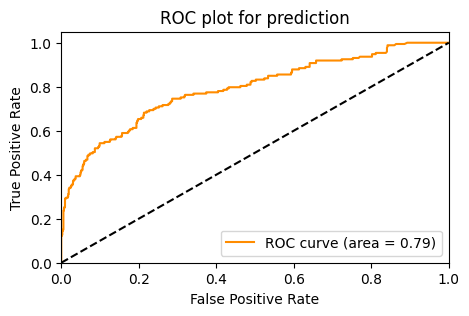

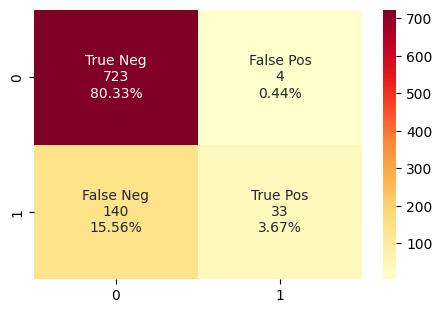

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       727
           1       0.89      0.19      0.31       173

    accuracy                           0.84       900
   macro avg       0.86      0.59      0.61       900
weighted avg       0.85      0.84      0.80       900


 
 
 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best train: 0.992998 using {'C': 10, 'gamma': 1, 'kernel': 'rbf', 'probability': True}
SVC
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.9666666666666667


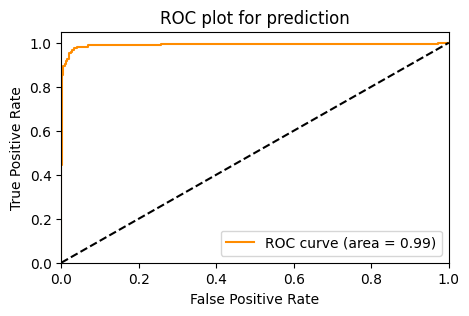

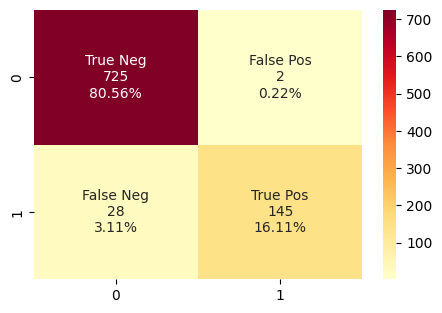

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       727
           1       0.99      0.84      0.91       173

    accuracy                           0.97       900
   macro avg       0.97      0.92      0.94       900
weighted avg       0.97      0.97      0.97       900


 
 
 

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best train: 0.990209 using {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 1000}
ExtraTreesClassifier
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.9377777777777778


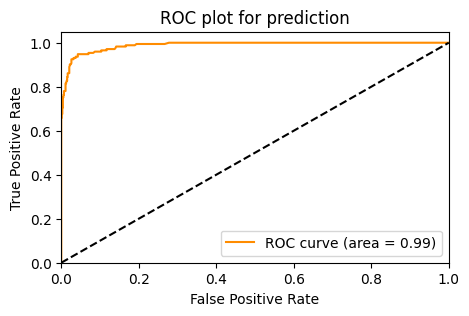

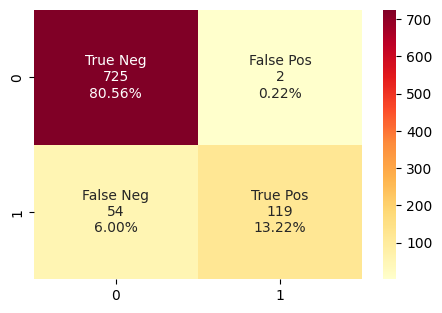

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       727
           1       0.98      0.69      0.81       173

    accuracy                           0.94       900
   macro avg       0.96      0.84      0.89       900
weighted avg       0.94      0.94      0.93       900


 
 
 

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best train: 0.968961 using {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}
GradientBoostingClassifier
Accuracy on Training Dataset :  1.0
Accuracy on Test Dataset :  0.9344444444444444


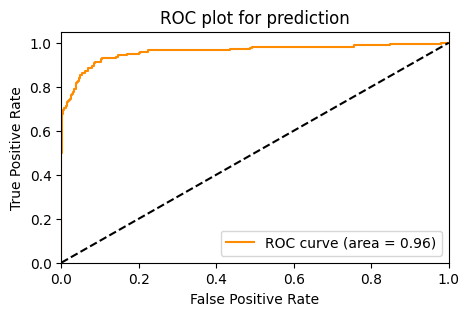

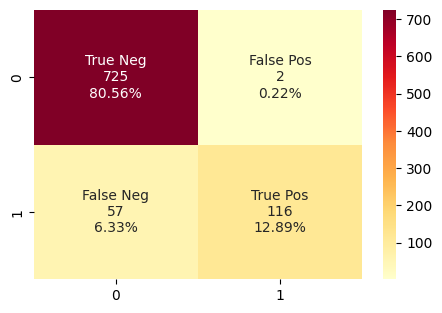

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       727
           1       0.98      0.67      0.80       173

    accuracy                           0.93       900
   macro avg       0.96      0.83      0.88       900
weighted avg       0.94      0.93      0.93       900


 
 
 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best train: 0.855625 using {'learning_rate': 0.2, 'n_estimators': 500}
AdaBoostClassifier
Accuracy on Training Dataset :  0.8753533069530809
Accuracy on Test Dataset :  0.8666666666666667


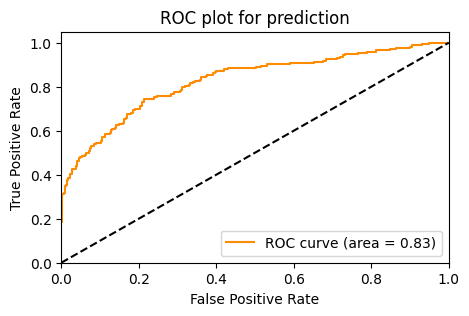

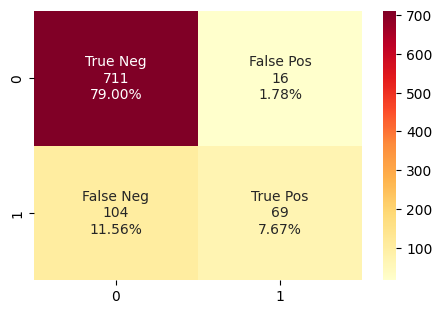

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       727
           1       0.81      0.40      0.53       173

    accuracy                           0.87       900
   macro avg       0.84      0.69      0.73       900
weighted avg       0.86      0.87      0.85       900


 
 
 



In [175]:
build_and_analysis(
    models=[LogisticRegression(), DecisionTreeClassifier(), 
            RandomForestClassifier(), SVC(),
            ExtraTreesClassifier(), GradientBoostingClassifier(),
            AdaBoostClassifier()],

    param_grids=[
                    [
                        {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], 'max_iter': [100, 1000, 2500, 5000]},
                        {'penalty': ['l1'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 1000, 2500, 5000]},
                        {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['saga'], 'max_iter': [100, 1000, 2500, 5000], 'l1_ratio': [0.25, 0.5, 0.75]}
                    ],
                    {
                        'max_depth': [5, 10, 15, 20, 25, 30],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4]
                    },
                    {
                        'n_estimators': [25, 50, 100, 150, 200, 250, 300, 400], 
                        'max_features': ['sqrt', 'log2', None], 
                        'max_depth': [3, 6, 9], 
                        'max_leaf_nodes': [3, 6, 9], 
                    }, 
                    {
                        'C': [0.1, 1, 10, 100],  
                        'gamma': [1, 0.1, 0.01],
                        'kernel': ['rbf', 'linear'],
                        'probability': [True]
                    }, 
                    {
                        'n_estimators': [200, 250, 300, 400, 500, 1000], 
                        'criterion': ['gini', 'entropy'],
                        'bootstrap': [True, False],
                        'max_features': ['sqrt', 'log2', None], 
                        # 'max_depth': [i for i in range(2, 15)], 
                        # 'min_samples_split': [2, 5, 8, 10, 15, 20],
                        # 'min_samples_leaf': [2, 5, 8, 10, 15, 20],
                        # 'max_leaf_nodes': [5, 8, 10, 15, 20, 25, 30]
                    },
                    {
                        'n_estimators': [100, 200, 250, 400, 500, 1000],
                        'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                        'max_depth': [3, 5, 10],
                    },
                    {
                        'n_estimators': [100, 200, 250, 400, 500, 1000],
                        'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                    }
                    
    ],

    x_train=x_train_7,
    y_train=y_train_7,
    x_test=x_test_7,
    y_test=y_test_7,
    index=7
)

<p style="color: yellow;"><strong>Với bộ dữ liệu df1</strong><p>

In [176]:
data1 = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Extra Trees', 'Gradient Boosting', 'AdaBoost'],
    'AUC': [0.72, 0.77, 0.79, 0.96, 0.97, 0.92, 0.84],
    'Accuracy (Train)': [0.84, 0.95, 0.84, 0.99, 1, 1, 0.88],
    'Accuracy (Test)': [0.85, 0.86, 0.84, 0.85, 0.9, 0.91, 0.87],
    'Recall (Class 1)': [0.25, 0.52, 0.15, 0.22, 0.51, 0.57, 0.43]
}
pd.DataFrame(data1)

Model   AUC  Accuracy (Train)  Accuracy (Test)  \
0  Logistic Regression  0.72              0.84             0.85   
1        Decision Tree  0.77              0.95             0.86   
2        Random Forest  0.79              0.84             0.84   
3                  SVM  0.96              0.99             0.85   
4          Extra Trees  0.97              1.00             0.90   
5    Gradient Boosting  0.92              1.00             0.91   
6             AdaBoost  0.84              0.88             0.87   

   Recall (Class 1)  
0              0.25  
1              0.52  
2              0.15  
3              0.22  
4              0.51  
5              0.57  
6              0.43

<p style="color: yellow;"><strong>Với bộ dữ liệu df2</strong><p>

In [177]:
data2 = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Extra Trees', 'Gradient Boosting', 'AdaBoost'],
    'AUC': [0.81, 0.71, 0.88, 0.98, 0.98, 0.89, 0.84],
    'Accuracy (Train)': [0.85, 0.98, 0.93, 1, 1, 1, 0.96],
    'Accuracy (Test)': [0.85, 0.87, 0.84, 0.91, 0.92, 0.86, 0.86],
    'Recall (Class 1)': [0.35, 0.42, 0.16, 0.55, 0.58, 0.28, 0.23]
}

pd.DataFrame(data2)

Model   AUC  Accuracy (Train)  Accuracy (Test)  \
0  Logistic Regression  0.81              0.85             0.85   
1        Decision Tree  0.71              0.98             0.87   
2        Random Forest  0.88              0.93             0.84   
3                  SVM  0.98              1.00             0.91   
4          Extra Trees  0.98              1.00             0.92   
5    Gradient Boosting  0.89              1.00             0.86   
6             AdaBoost  0.84              0.96             0.86   

   Recall (Class 1)  
0              0.35  
1              0.42  
2              0.16  
3              0.55  
4              0.58  
5              0.28  
6              0.23

<p style="color: yellow;"><strong>Với bộ dữ liệu df3</strong><p>

In [181]:
data3 = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Extra Trees', 'Gradient Boosting', 'AdaBoost'],
    'AUC': [0.81, 0.73, 0.88, 0.98, 0.98, 0.9, 0.84],
    'Accuracy (Train)': [0.86, 0.98, 0.93, 1.0, 1.0, 1.0, 0.96],
    'Accuracy (Test)': [0.85, 0.87, 0.84, 0.91, 0.92, 0.87, 0.86],
    'Recall (Class 1)': [0.35, 0.42, 0.14, 0.51, 0.56, 0.32, 0.23]
}

pd.DataFrame(data3)

Model   AUC  Accuracy (Train)  Accuracy (Test)  \
0  Logistic Regression  0.81              0.86             0.85   
1        Decision Tree  0.73              0.98             0.87   
2        Random Forest  0.88              0.93             0.84   
3                  SVM  0.98              1.00             0.91   
4          Extra Trees  0.98              1.00             0.92   
5    Gradient Boosting  0.90              1.00             0.87   
6             AdaBoost  0.84              0.96             0.86   

   Recall (Class 1)  
0              0.35  
1              0.42  
2              0.14  
3              0.51  
4              0.56  
5              0.32  
6              0.23

<p style="color: yellow;"><strong>Với bộ dữ liệu df4</strong><p>

In [182]:
data4 = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Extra Trees', 'Gradient Boosting', 'AdaBoost'],
    'AUC': [0.73, 0.77, 0.81, 0.98, 0.98, 0.93, 0.84],
    'Accuracy (Train)': [0.84, 0.93, 0.86, 0.99, 1.0, 1.0, 0.91],
    'Accuracy (Test)': [0.84, 0.86, 0.83, 0.88, 0.93, 0.9, 0.86],
    'Recall (Class 1)': [0.28, 0.33, 0.06, 0.38, 0.6, 0.46, 0.22]
}

pd.DataFrame(data4)

Model   AUC  Accuracy (Train)  Accuracy (Test)  \
0  Logistic Regression  0.73              0.84             0.84   
1        Decision Tree  0.77              0.93             0.86   
2        Random Forest  0.81              0.86             0.83   
3                  SVM  0.98              0.99             0.88   
4          Extra Trees  0.98              1.00             0.93   
5    Gradient Boosting  0.93              1.00             0.90   
6             AdaBoost  0.84              0.91             0.86   

   Recall (Class 1)  
0              0.28  
1              0.33  
2              0.06  
3              0.38  
4              0.60  
5              0.46  
6              0.22

<p style="color: yellow;"><strong>Với bộ dữ liệu df5</strong><p>

In [186]:
data5 = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Extra Trees', 'Gradient Boosting', 'AdaBoost'],
    'AUC': [0.73, 0.78, 0.81, 0.98, 0.98, 0.93, 0.84],
    'Accuracy (Train)': [0.84, 0.93, 0.87, 0.99, 1.0, 1.0, 0.91],
    'Accuracy (Test)': [0.84, 0.85, 0.83, 0.89, 0.92, 0.89, 0.86],
    'Recall (Class 1)': [0.26, 0.33, 0.1, 0.39, 0.59, 0.4, 0.22]
}

pd.DataFrame(data5)

Model   AUC  Accuracy (Train)  Accuracy (Test)  \
0  Logistic Regression  0.73              0.84             0.84   
1        Decision Tree  0.78              0.93             0.85   
2        Random Forest  0.81              0.87             0.83   
3                  SVM  0.98              0.99             0.89   
4          Extra Trees  0.98              1.00             0.92   
5    Gradient Boosting  0.93              1.00             0.89   
6             AdaBoost  0.84              0.91             0.86   

   Recall (Class 1)  
0              0.26  
1              0.33  
2              0.10  
3              0.39  
4              0.59  
5              0.40  
6              0.22

<p style="color: yellow;"><strong>Với bộ dữ liệu df6</strong><p>

In [187]:
data6 = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'ExtraTrees', 'GradientBoosting', 'AdaBoost'],
    'AUC': [0.73, 0.77, 0.81, 0.88, 0.98, 0.92, 0.84],
    'Accuracy (Train)': [0.84, 0.93, 0.86, 0.91, 1.0, 1.0, 0.91],
    'Accuracy (Test)': [0.84, 0.86, 0.83, 0.9, 0.92, 0.89, 0.85],
    'Recall (Class 1)': [0.3, 0.32, 0.07, 0.48, 0.6, 0.45, 0.22]
}

pd.DataFrame(data6)

Model   AUC  Accuracy (Train)  Accuracy (Test)  \
0  Logistic Regression  0.73              0.84             0.84   
1        Decision Tree  0.77              0.93             0.86   
2        Random Forest  0.81              0.86             0.83   
3                  SVM  0.88              0.91             0.90   
4           ExtraTrees  0.98              1.00             0.92   
5     GradientBoosting  0.92              1.00             0.89   
6             AdaBoost  0.84              0.91             0.85   

   Recall (Class 1)  
0              0.30  
1              0.32  
2              0.07  
3              0.48  
4              0.60  
5              0.45  
6              0.22

<p style="color: yellow;"><strong>Với bộ dữ liệu df7</strong><p>

In [188]:
data7 = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Extra Trees', 'Gradient Boosting', 'AdaBoost'],
    'AUC': [0.75, 0.81, 0.79, 0.99, 0.99, 0.96, 0.83],
    'Accuracy (Train)': [0.84, 0.96, 0.84, 1.0, 1.0, 1.0, 0.88],
    'Accuracy (Test)': [0.83, 0.88, 0.84, 0.97, 0.94, 0.93, 0.87],
    'Recall (Class 1)': [0.29, 0.57, 0.19, 0.84, 0.69, 0.67, 0.4]
}

pd.DataFrame(data7)

Model   AUC  Accuracy (Train)  Accuracy (Test)  \
0  Logistic Regression  0.75              0.84             0.83   
1        Decision Tree  0.81              0.96             0.88   
2        Random Forest  0.79              0.84             0.84   
3                  SVM  0.99              1.00             0.97   
4          Extra Trees  0.99              1.00             0.94   
5    Gradient Boosting  0.96              1.00             0.93   
6             AdaBoost  0.83              0.88             0.87   

   Recall (Class 1)  
0              0.29  
1              0.57  
2              0.19  
3              0.84  
4              0.69  
5              0.67  
6              0.40

<p style="color: red;"><strong>Kết luận: Ở bài toán này sẽ sử dụng <span style="color: yellow;">AUC</span> và <span style="color: yellow;">Recall_1</span> để đánh giá chất lượng của mô hình</strong></p>
<p>+ Với mỗi bộ dữ liệu thì đều có 2 mô hình khá tốt là: SVM và ExtraTrees nhưng Recall_1 ở một số bộ dữ liệu vẫn còn tương đối thấp</p>
<p>+ Bộ dữ liệu phù hợp nhất với model LogisticRegression là: df3</p>
<p>+ Bộ dữ liệu phù hợp nhất với model DecisionTree là: df7</p>
<p>+ Bộ dữ liệu phù hợp nhất với model RandomForest là: df7</p>
<p>+ Bộ dữ liệu phù hợp nhất với model SVM là: df7</p>
<p>+ Bộ dữ liệu phù hợp nhất với model ExtraTrees là: df7</p>
<p>+ Bộ dữ liệu phù hợp nhất với model GradientBoosting là: df7</p>
<p>+ Bộ dữ liệu phù hợp nhất với model AdaBoost là: df7</p>

<p>==> Có thể thấy rằng với bộ dữ liệu df7 thì các mô hình đều tốt hơn các bộ dữ liệu khác
<p>==> Và mô hình tốt nhất sử dụng cho bài toán này là: <span style="color:yellow;">Support Vector Machine</span> với bộ dữ liệu <span style="color: yellow;">df7</span></p>

<h3> Credit score for dataset test

In [69]:
def compute_credit_score(p):
    try:
        factor = 25 / np.log(2)
        offset = 600 - factor * np.log(50)
        val = (1-p) / p
        score = offset + factor * np.log(val)
        return round(score, 2)
    except:
        return 2000

In [70]:
def distribution_score(x0, x1):
    fig, axes = plt.subplots(1,2,figsize=(12, 4))

    # Vẽ đồ thị histogram và đường KDE cho tập train
    sns.histplot(x0["Score"], bins=15, kde=True, ax=axes[0])
    axes[0].set_title(f"Phân phối của score với class 0 - trả được nợ")
    axes[0].set_ylabel("Tần suất")
    axes[0].set_xlabel(None)
    

    # Vẽ đồ thị histogram và đường KDE cho test
    sns.histplot(x1["Score"], bins=15, kde=True, ax=axes[1])
    axes[1].set_title(f"Phân phối của score với class 1 - vỡ nợ")
    axes[1].set_ylabel("Tần suất")
    axes[1].set_xlabel(None)
    

    # Căn chỉnh và hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

In [71]:
def distribution(x,y, model):
    model = pickle.load(open(model, 'rb'))
    x_test = x.copy()
    pred_prob_test = model.predict_proba(x_test)[:,1]
    x_test["Prob"] = pred_prob_test
    x_test["Score"] = x_test["Prob"].apply(lambda x: compute_credit_score(x))
    x_test["BAD"] = y

    class1 = x_test[x_test["BAD"] == 1]
    class0 = x_test[x_test["BAD"] == 0]
    
    distribution_score(class0, class1)

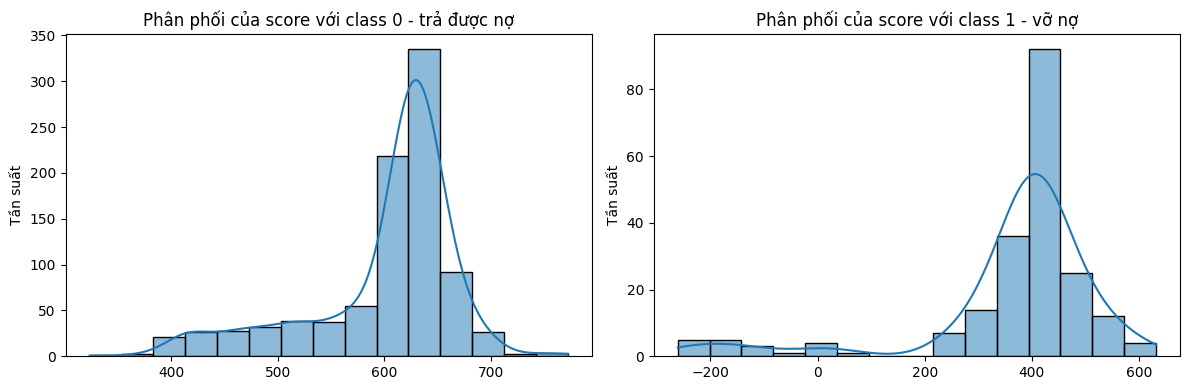

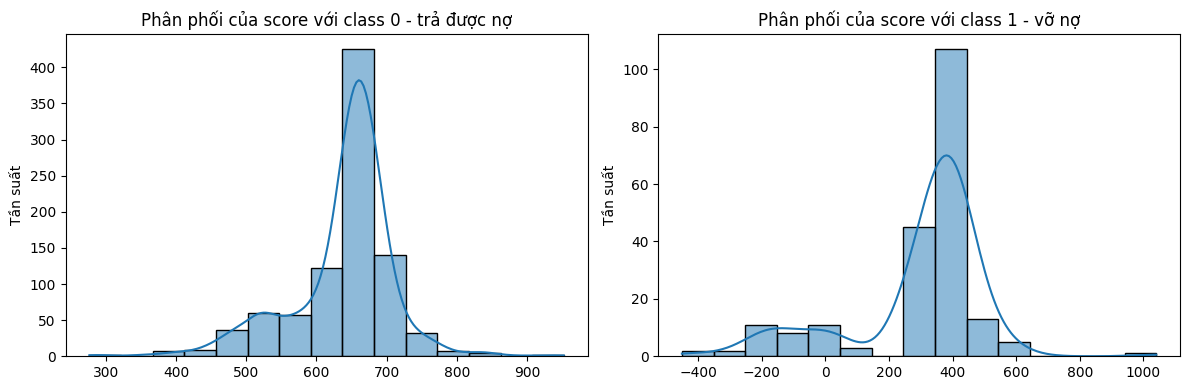

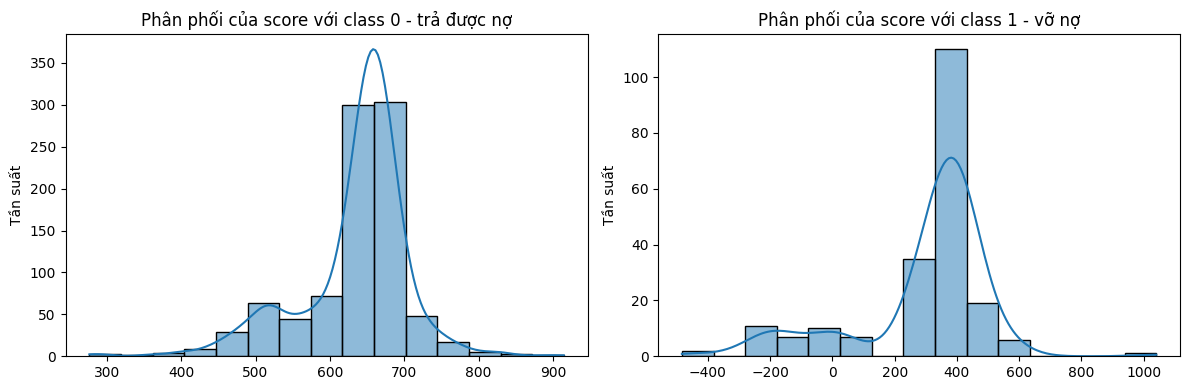

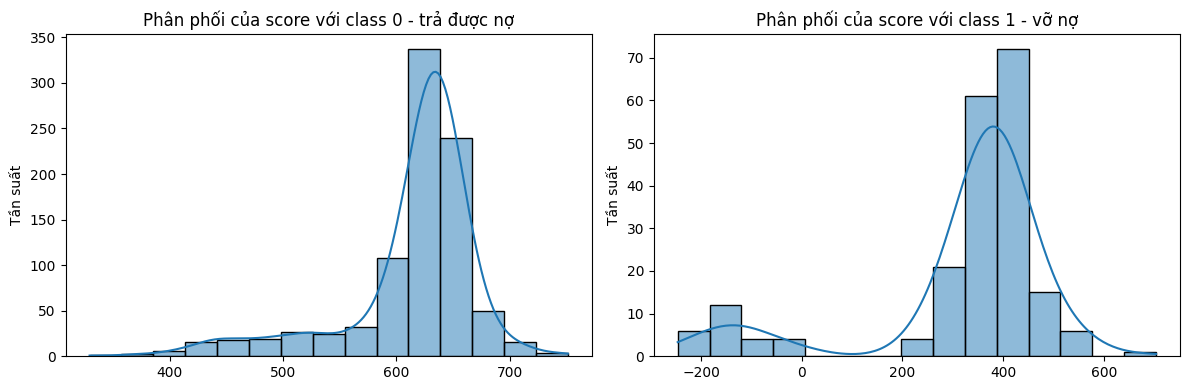

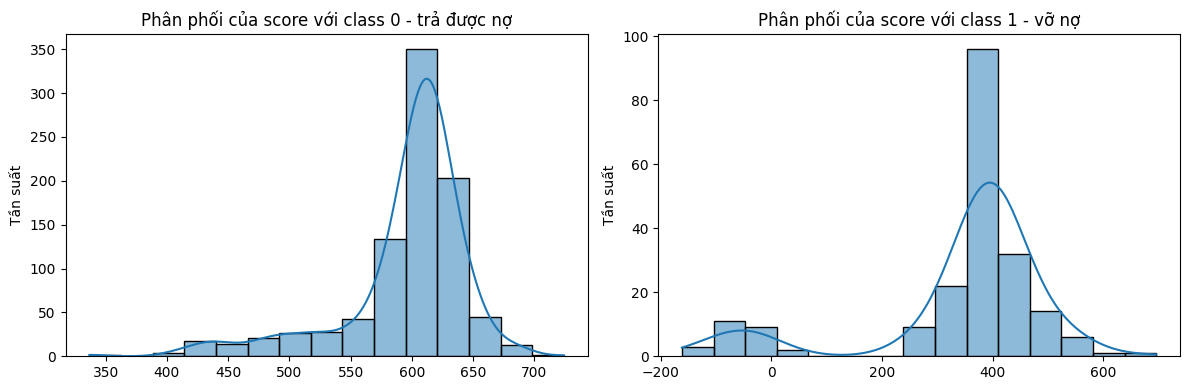

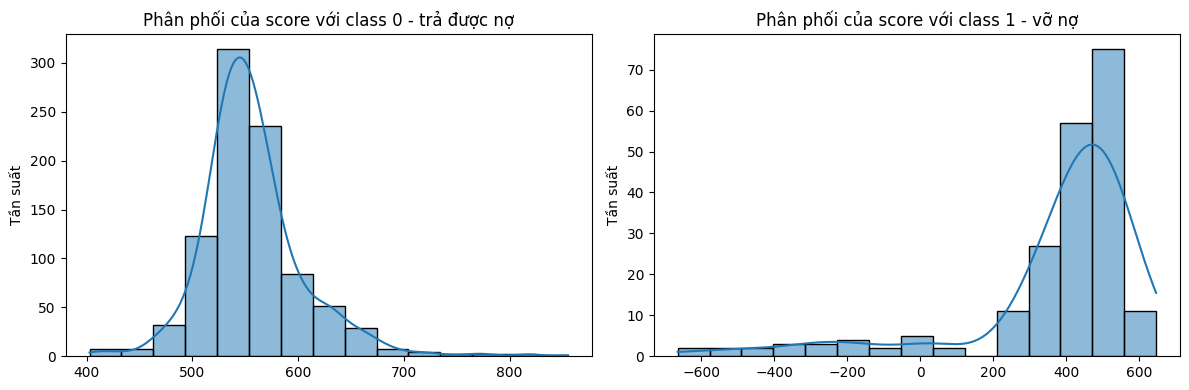

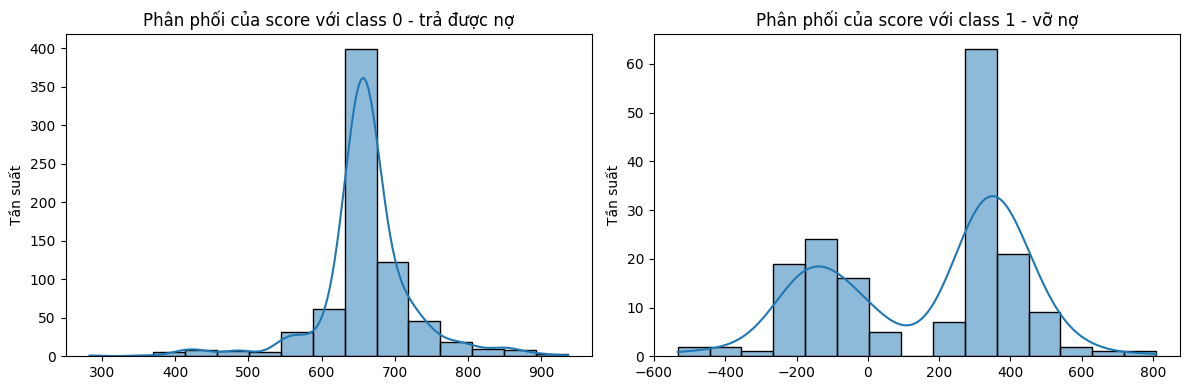

In [125]:
distribution(x_test_1, y_test_1, './model_df1/SVC.pickle') # Loại
distribution(x_test_2, y_test_2, './model_df2/SVC.pickle') # Loại
distribution(x_test_3, y_test_3, './model_df3/SVC.pickle') # Loại
distribution(x_test_4, y_test_4, './model_df4/SVC.pickle') # Loại
distribution(x_test_5, y_test_5, './model_df5/SVC.pickle') # Loại
distribution(x_test_6, y_test_6, './model_df6/SVC.pickle') # Loại
distribution(x_test_7, y_test_7, './model_df7/SVC.pickle') # Nhận

# Bộ dữ liệu 1,2,3,4,5,6,7 ổn nhất với SVC

In [2]:
import numpy as np
factor = 25 / np.log(2)
offset = 600 - factor * np.log(50)
val = np.e ** ((355.08-offset)/factor)
p = 1 / (val + 1)
p

0.9467784281359115